In [21]:
library(Seurat)
library(enrichR)
library(ggplot2)
library(dplyr)
library(stringr)
library(httr)
library(jsonlite)
library(hash)
library(readr)
library(purrr)
library(RColorBrewer)  # For color palettes
library(DESeq2)
library(ggpubr)


In [22]:
# Here's the code snippet to check versions of installed R libraries
# Since I can't execute R code directly here, you can run the following R script in your environment:

# Get the installed package versions
installed_packages <- installed.packages()

# List of packages to check
packages <- c("Seurat", "enrichR", "ggplot2", "dplyr", "stringr", 
              "httr", "jsonlite", "hash", "readr", "purrr", 
              "RColorBrewer", "DESeq2", "ggpubr")

# Fetch the version of each package
package_versions <- installed_packages[packages, c("Package", "Version")]

# Convert to a dataframe for better viewing
package_versions_df <- as.data.frame(package_versions, stringsAsFactors = FALSE)

# Print the versions
print(package_versions_df)

# Copy this code into your R session to see the versions of the libraries. 



                  Package Version
Seurat             Seurat 4.3.0.1
enrichR           enrichR     3.2
ggplot2           ggplot2   3.4.4
dplyr               dplyr   1.1.3
stringr           stringr   1.5.0
httr                 httr   1.4.7
jsonlite         jsonlite   1.8.7
hash                 hash 2.2.6.3
readr               readr   2.1.5
purrr               purrr   1.0.2
RColorBrewer RColorBrewer   1.1-3
DESeq2             DESeq2  1.34.0
ggpubr             ggpubr   0.6.0


In [15]:
samples <- c("ZWV08", "ZWV10", "ZWV14","ZWV16")
scRNA <- c('Du13','Du27', 'Du53', 'Du55')

durva <- readRDS("integrated_data/durva_subset_reintegrate.rds")
durva[["CellName"]] <- colnames(durva)


In [16]:
# Scale the data (this step is important before PCA)
durva <- ScaleData(durva)

# Perform PCA
durva <- RunPCA(durva, npcs = 30)



Centering and scaling data matrix

PC_ 1 
Positive:  MIR100HG, MECOM, SFTPB, ERRFI1, PARD3, EFNA5, SGMS2, GLIS3, WWTR1, F3 
	   SDK1, CHL1, NEDD4L, RBMS3, MACROD2, GPRC5A, TANC2, OSMR, CYP4B1, LIMCH1 
	   PHACTR3, PTCHD4, LMO7, TCIM, NEBL, ANXA2, RBPMS, PID1, AASS, LTF 
Negative:  THEMIS, SAMSN1, FYB1, IL7R, B2M, AOAH, PDE4B, SRGN, LINC01934, SLC7A5 
	   IGHG1, FCRL5, IGKC, CEP128, POU2AF1, LRMP, PIM2, BLK, ZEB2, NELL2 
	   MARCH1, FAR2, ZEB1, BACH2, IGHGP, WDFY4, MZB1, MS4A1, DERL3, SSPN 
PC_ 2 
Positive:  SFTPB, SGMS2, ROS1, CYP4B1, ALPL, SLC34A2, AGBL1, NEDD4L, HOPX, ZNF385B 
	   SFTPA2, AC044810.2, CD55, CTSE, SFTPA1, F3, ARFGEF3, P3H2, TMC5, SYN3 
	   BPIFB1, STEAP4, ADGRV1, KRT7, AC096531.2, RIMS1, LMO7, CDH1, SLC7A2, MGST1 
Negative:  LAMA2, CACNA1C, CRISPLD2, SERPINE1, COL4A1, MMP19, COL6A3, LSAMP, SCN7A, COL4A2 
	   COL5A2, FBN1, PDLIM3, COL1A2, ABI3BP, CALD1, SGIP1, NAV3, PDZRN3, UNC5C 
	   PDGFRA, ROBO2, COL3A1, PRR16, TENM3, CCN4, GFPT2, FSTL1, ADAMTS12, ANK2 
PC_ 3 
Positi

In [17]:

radius_distances <- c(14, 14, 14, 14)
afm_groups <- list()

for (i in seq_along(samples)) {
  sample <- samples[i]
  
  # Read data files
  tissue <- read_csv(paste0(sample, "/outs/spatial/adjusted_tissue_positions.csv"))
  afm <- read_csv(paste0(sample, "/", sample, "_new/final_aligned_afm.csv"))
  print(min(afm[["Young's Modulus [Pa]"]]))
  print(max(afm[["Young's Modulus [Pa]"]]))

  cell_types <- read_csv(paste0("UpdatedCytoSpace/",sample, "/cytospace_results/cell_type_assignments_by_spot.csv")) %>%
    select(-`Total cells`)
  assignments <- read_csv(paste0("UpdatedCytoSpace/",sample, "/cytospace_results/assigned_locations.csv"))
  
  print(sample)
  
  row_afm <- vector("list")
  
  # Map operations to each row in tissue
  spot_av_afm_dict <- map_dfr(setNames(tissue$Barcode, tissue$Barcode), function(barcode) {
    x_coord <- tissue$X[tissue$Barcode == barcode]
    y_coord <- tissue$Y[tissue$Barcode == barcode]
    
    # Compute distances and filter
    afm$distance <- sqrt((afm$X - x_coord)^2 + (afm$Y - y_coord)^2)
    filtered_afm_distance <- afm %>% filter(distance < radius_distances[i])
    
    # Mean Young's Modulus calculation
    mean_youngs_modulus <- mean(filtered_afm_distance$`Young's Modulus [Pa]`, na.rm = TRUE)
    list(SpotID = paste0(sample, "_", barcode), avAFM = mean_youngs_modulus)
  }) %>%
    bind_rows()

    
  # Append the number of filtered records
  row_afm <- c(row_afm, length(spot_av_afm_dict$avAFM))

  assignments <- left_join(assignments, spot_av_afm_dict, by = "SpotID")
  print(min(assignments$avAFM,na.rm = TRUE))
  print(max(assignments$avAFM,na.rm = TRUE))

  write_csv(assignments, paste0("UpdatedCytoSpace/",sample, "/cytospace_results/cell_type_assignments_by_spot_avAFM.csv"))
  afm_groups[[i]] <- row_afm
}



Rows: 1298 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Barcode
dbl (2): X, Y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 14742 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Filename
dbl (13): ...1, Unnamed: 0, Position Index, X Position, Y Position, Baseline...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 500.002
[1] 4999.94


Rows: 1298 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): SpotID
dbl (8): Malignant, Nonmalignant.others, Fibroblasts, Endothelial, B.cells, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 5864 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): UniqueCID, OriginalCID, CellType, SpotID
dbl (2): row, col

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "ZWV08"
[1] 560.3165
[1] 4772.92


New names:
• `` -> `...1`
Rows: 1534 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Barcode
dbl (5): ...1, X Coordinate, Y Coordinate, X, Y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 16790 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Filename
dbl (14): ...1, Unnamed: 0.1, Unnamed: 0, Position Index, X Position, Y Posi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 500.517
[1] 4999.84


Rows: 1534 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): SpotID
dbl (8): Malignant, Nonmalignant.others, Fibroblasts, Endothelial, B.cells, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 6906 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): UniqueCID, OriginalCID, CellType, SpotID
dbl (2): row, col

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "ZWV10"
[1] 632.335
[1] 4515.56


Rows: 1271 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Barcode
dbl (2): X, Y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 9209 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Filename
dbl (13): ...1, Unnamed: 0, Position Index, X Position, Y Position, Baseline...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 500.621
[1] 4997.49


Rows: 1274 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): SpotID
dbl (8): Malignant, Fibroblasts, B.cells, Myeloid, T.cells, Endothelial, Non...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 5734 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): UniqueCID, OriginalCID, CellType, SpotID
dbl (2): row, col

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "ZWV14"
[1] 516.3945
[1] 4707.25


Rows: 777 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Barcode
dbl (2): X, Y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 14513 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Filename
dbl (13): ...1, Unnamed: 0, Position Index, X Position, Y Position, Baseline...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 500.31
[1] 4997.38


Rows: 776 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): SpotID
dbl (8): Malignant, Fibroblasts, Endothelial, Myeloid, B.cells, T.cells, Non...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3481 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): UniqueCID, OriginalCID, CellType, SpotID
dbl (2): row, col

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "ZWV16"
[1] 558.094
[1] 4852.77


In [19]:
scRNA.AFM <- c()
spatial.AFM <- c()
sc_rna_key <- 0

for (x in samples){
    sc_rna_key <- sc_rna_key + 1
    print(x)
    seu <- subset(durva, orig.ident == scRNA[sc_rna_key])

    spatial <- Load10X_Spatial(data.dir = paste0(x, "/spatial_data"), filename = 'filtered_feature_bc_matrix.h5', assay = 'spatial')
    spatial.AFM <- c(spatial.AFM, spatial)

}

merged_spatial <- Reduce(function(x, y) merge(x, y), spatial.AFM)

# Check the merged object
print(merged_spatial)


[1] "ZWV08"
[1] "ZWV10"
[1] "ZWV14"
[1] "ZWV16"


Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”


An object of class Seurat 
18085 features across 4844 samples within 1 assay 
Active assay: spatial (18085 features, 0 variable features)
 4 images present: slice1, slice1.1, slice1.2, slice1.3


In [5]:
scRNA.AFM <- c()
spatial.AFM <- c()
sc_rna_key <- 0

for (x in samples){
    sc_rna_key <- sc_rna_key + 1
    print(x)
    seu <- subset(durva, orig.ident == scRNA[sc_rna_key])
   

    tissue = read.csv(paste0(x, "/outs/spatial/adjusted_tissue_positions.csv"))
    afm = read.csv(paste0(x, "/", x, "_new/", "final_aligned_afm.csv"))
    alignment_avAFM <- read.csv(paste0("UpdatedCytoSpace/",x,"/cytospace_results/cell_type_assignments_by_spot_avAFM.csv"))
    alignment_avAFM$OriginalCID <-sub(".*?_", "", alignment_avAFM$OriginalCID)
    alignment_avAFM$OriginalCID <- paste(scRNA[[sc_rna_key]], alignment_avAFM$OriginalCID, sep="_")
    domains <- read.csv(paste0(x, "/outs/results/spatial_domain_assingments.csv"))
    domains$X <- paste0(x, "_", domains$X)
    domains$squidpy_domains <- paste0(x, "_", domains$squidpy_domains)
    domains$X
    # Assuming your dataframes are named alignment_avAFM and domains
    alignment_avAFM <- alignment_avAFM %>%
      left_join(domains %>% select(X, squidpy_domains), by = c("SpotID" = "X"))

    domain_dict <- setNames(alignment_avAFM$squidpy_domains, alignment_avAFM$OriginalCID)

    avAFM_dict <- setNames(alignment_avAFM$avAFM, alignment_avAFM$OriginalCID)
    
    seu_in_afm <- subset(durva, subset = CellName %in% alignment_avAFM$OriginalCID )
    seu_in_afm@meta.data$avAFM <- avAFM_dict[match(seu_in_afm@meta.data$CellName, names(avAFM_dict))]
    seu_in_afm@meta.data$squidpy_domains <- domain_dict[match(seu_in_afm@meta.data$CellName, names(domain_dict))]

    seu_in_afm <- subset(seu_in_afm, subset = avAFM != "NA")
    DefaultAssay(seu_in_afm)<- "RNA"
    seu_in_afm <- ScaleData(seu_in_afm)

    
    alignment_avAFM$SpotID <-sub(".*?_", "", alignment_avAFM$SpotID)
    avAFM_dict <- setNames(alignment_avAFM$avAFM, alignment_avAFM$SpotID)
    domain_dict <- setNames(alignment_avAFM$squidpy_domains, alignment_avAFM$SpotID)

    
    spatial <- Load10X_Spatial(data.dir = paste0(x, "/spatial_data"), filename = 'filtered_feature_bc_matrix.h5', assay = 'spatial')
    spatial[["CellName"]] <- colnames(spatial)             
    spatial <- subset(spatial, subset = CellName %in% alignment_avAFM$SpotID )
    spatial@meta.data$avAFM <- avAFM_dict[match(spatial@meta.data$CellName, names(avAFM_dict))]
    spatial@meta.data$squidpy_domains <- domain_dict[match(spatial@meta.data$CellName, names(domain_dict))]

    spatial <- subset(spatial, subset = avAFM != "NA")
    spatial[["origin"]] = x

    
    spatial.AFM <- c(spatial.AFM, spatial)
    scRNA.AFM <- c(scRNA.AFM, seu_in_afm)
}

[1] "ZWV08"


Centering and scaling data matrix



[1] "ZWV10"


Centering and scaling data matrix



[1] "ZWV14"


Centering and scaling data matrix



[1] "ZWV16"


Centering and scaling data matrix



In [6]:
signatures <- list()
for (seu in scRNA.AFM){
    seu <- subset(seu, subset = avAFM  > 300)

    lcv_data <- seu@meta.data$avAFM
    lcv_data <- as.vector((unlist(lcv_data)))

    quartile_breaks <- quantile(lcv_data, probs = c(0, 0.25, 0.50, 0.75, 1), na.rm = TRUE)
    
    seu@meta.data$quartile <- cut(lcv_data, 
                                   breaks = quartile_breaks, 
                                   include.lowest = TRUE,
                                   labels = c("Q1", "Q2", "Q3", "Q4"))
    
    seu@meta.data$quartile <- lapply(seu@meta.data$CellName,
                                                function(x) seu@meta.data[x,]$quartile)

    Idents(seu) <- 'quartile'
    GSEA_Markers <- FindAllMarkers(seu, logfc.threshold = 0.075 )       
    
    Signature <- GSEA_Markers[GSEA_Markers$cluster == "Q4" & GSEA_Markers$p_val_adj < 1 & 
                  GSEA_Markers$avg_log2FC >0, ]$gene

    Signature <- c(Signature,                                           
    GSEA_Markers[GSEA_Markers$cluster == "Q1"  & GSEA_Markers$p_val_adj < 1 &
                  GSEA_Markers$avg_log2FC <0, ]$gene)


    print(Signature)
    signatures <- append(signatures, list(Signature))
}

Calculating cluster Q1

Calculating cluster Q2

Calculating cluster Q3

Calculating cluster Q4



character(0)


Calculating cluster Q1

Calculating cluster Q2

Calculating cluster Q3

Calculating cluster Q4



character(0)


Calculating cluster Q1

Calculating cluster Q2

Calculating cluster Q3

Calculating cluster Q4



character(0)


Calculating cluster Q1

Calculating cluster Q2

Calculating cluster Q3

Calculating cluster Q4



 [1] "ZNF706" "ITM2C"  "LIME1"  "H2AFZ"  "DERL3"  "SAMD3"  "SMIM15" "ICAM3" 
 [9] "RAC2"   "PRDM1"  "RGS1"   "ADA2"  


In [7]:
spatial_signatures <- list()
for (seu in spatial.AFM){
    seu <- subset(seu, subset = avAFM  > 300)

    lcv_data <- seu@meta.data$avAFM
    lcv_data <- as.vector((unlist(lcv_data)))

    quartile_breaks <- quantile(lcv_data, probs = c(0, 0.25, 0.50, 0.75, 1), na.rm = TRUE)
    
    seu@meta.data$quartile <- cut(lcv_data, 
                                   breaks = quartile_breaks, 
                                   include.lowest = TRUE,
                                   labels = c("Q1", "Q2", "Q3", "Q4"))
    
    seu@meta.data$quartile <- lapply(seu@meta.data$CellName,
                                                function(x) seu@meta.data[x,]$quartile)

    Idents(seu) <- 'quartile'
    GSEA_Markers <- FindAllMarkers(seu )       
    
    Signature <- GSEA_Markers[GSEA_Markers$cluster == "Q4" & GSEA_Markers$p_val_adj < 1 & 
                  GSEA_Markers$avg_log2FC >0, ]$gene

    Signature <- c(Signature,                                           
    GSEA_Markers[GSEA_Markers$cluster == "Q1"  & GSEA_Markers$p_val_adj < 1 &
                  GSEA_Markers$avg_log2FC <0, ]$gene)


    print(Signature)
    spatial_signatures <- append(spatial_signatures, list(Signature))
}

Calculating cluster Q1

Calculating cluster Q2

Calculating cluster Q3

Calculating cluster Q4



[1] "RFNG"


Calculating cluster Q1

Calculating cluster Q2

Calculating cluster Q3

Calculating cluster Q4



character(0)


Calculating cluster Q1

Calculating cluster Q2

Calculating cluster Q3

Calculating cluster Q4



character(0)


Calculating cluster Q1

Calculating cluster Q2

Calculating cluster Q3

Calculating cluster Q4



character(0)


,orig.ident,nCount_spatial,nFeature_spatial,CellName,avAFM,squidpy_domains,origin
,<fct>,<dbl>,<int>,<chr>,<dbl>,<chr>,<chr>
AACAGGTTATTGCACC-1,SeuratProject,7791,2192,AACAGGTTATTGCACC-1,1974.761,ZWV08_6,ZWV08
AACCAAGGTATCAGGC-1,SeuratProject,25473,4257,AACCAAGGTATCAGGC-1,2183.477,ZWV08_3,ZWV08
AACCTACAGAGGTAGT-1,SeuratProject,18290,3684,AACCTACAGAGGTAGT-1,1773.004,ZWV08_6,ZWV08
AACGAGCTAATAACTA-1,SeuratProject,14970,3833,AACGAGCTAATAACTA-1,2420.151,ZWV08_2,ZWV08
AACTAGGCCTGACACC-1,SeuratProject,22445,3995,AACTAGGCCTGACACC-1,2582.638,ZWV08_3,ZWV08
AACTATTCTGCGGCCT-1,SeuratProject,22498,3449,AACTATTCTGCGGCCT-1,1938.705,ZWV08_3,ZWV08


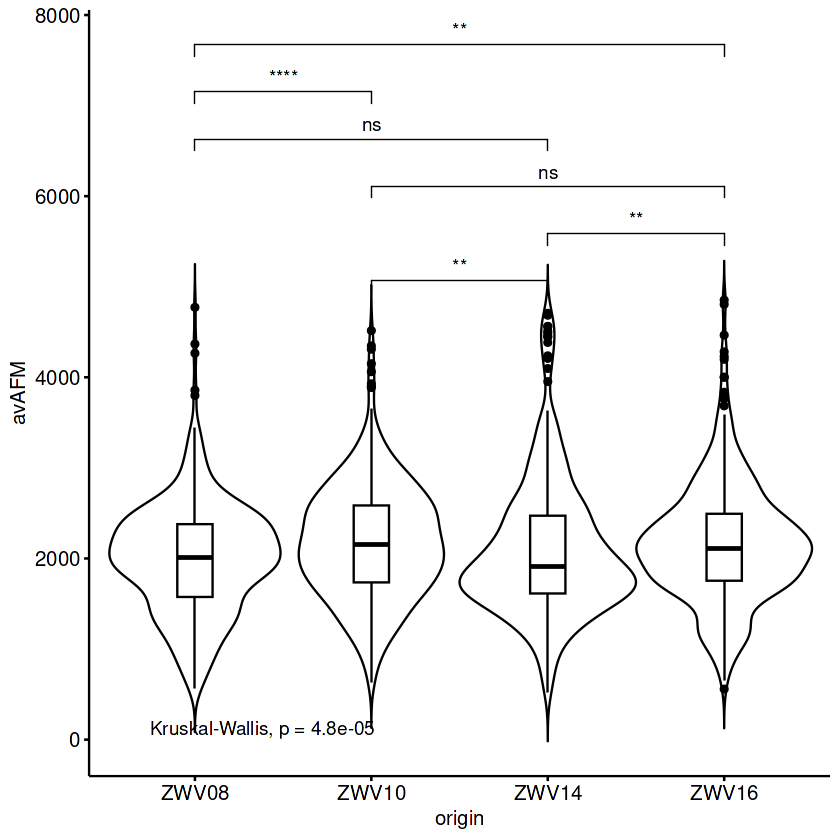

In [9]:
library(ggpubr)
my_comparisons <- list( c("ZWV10", "ZWV14"), c("ZWV16", "ZWV14"), c("ZWV10", "ZWV16") ,
                      c("ZWV08", "ZWV14"), c("ZWV10", "ZWV08"), c("ZWV08", "ZWV16"))

metadata_list <- lapply(spatial.AFM, function(x) {
  x@meta.data
})

# Combine the metadata into a single dataframe
combined_metadata <- bind_rows(metadata_list)

# Display the combined metadata
head(combined_metadata)
ggviolin(combined_metadata, x = "origin", y = "avAFM",
         add = "boxplot", add.params = list(fill = "white"))+
  stat_compare_means(comparisons = my_comparisons, label = "p.signif")+ # Add significance levels
  stat_compare_means(label.y = 50)    

In [10]:
unique(combined_metadata$origin)

[1] "ZWV08" "ZWV10" "ZWV14" "ZWV16"

Connection changed to https://maayanlab.cloud/Enrichr/

Connection is Live!



,geneCoverage,genesPerTerm,libraryName,link,numTerms,appyter,categoryId
,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>
1,13362,275,Genome_Browser_PWMs,http://hgdownload.cse.ucsc.edu/goldenPath/hg18/database/,615,ea115789fcbf12797fd692cec6df0ab4dbc79c6a,1
2,27884,1284,TRANSFAC_and_JASPAR_PWMs,http://jaspar.genereg.net/html/DOWNLOAD/,326,7d42eb43a64a4e3b20d721fc7148f685b53b6b30,1
3,6002,77,Transcription_Factor_PPIs,,290,849f222220618e2599d925b6b51868cf1dab3763,1
4,47172,1370,ChEA_2013,http://amp.pharm.mssm.edu/lib/cheadownload.jsp,353,7ebe772afb55b63b41b79dd8d06ea0fdd9fa2630,7
5,47107,509,Drug_Perturbations_from_GEO_2014,http://www.ncbi.nlm.nih.gov/geo/,701,ad270a6876534b7cb063e004289dcd4d3164f342,7
6,21493,3713,ENCODE_TF_ChIP-seq_2014,http://genome.ucsc.edu/ENCODE/downloads.html,498,497787ebc418d308045efb63b8586f10c526af51,7


Uploading data to Enrichr... Done.
  Querying MSigDB_Hallmark_2020... Done.
  Querying GO_Biological_Process_2023... Done.
Parsing results... Done.


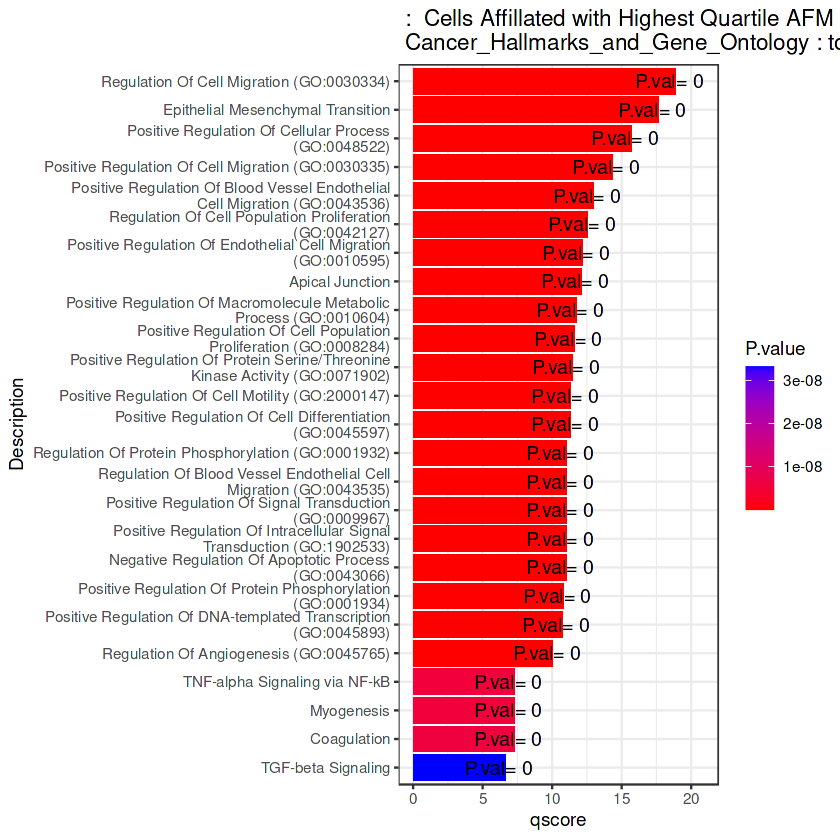

In [11]:


mechano_signature <- unique(read.csv("../mice_samples/all_completed_alignments/LCV01/mechanosensative_geneset.csv")$Symbol)


genes <- mechano_signature

# Load Enrichr
setEnrichrSite("Enrichr") # Human genes
websiteLive <- TRUE
dbs <- listEnrichrDbs()
if (is.null(dbs)) websiteLive <- FALSE
if (websiteLive) head(dbs)
dbs <- c("MSigDB_Hallmark_2020","GO_Biological_Process_2023")

#dbs <- c("MSigDB_Hallmark_2020","MSigDB_Hallmark_2020")

if (websiteLive) {
  enriched <- enrichr(genes, dbs)
}
mut_enr_ch<-mutate(enriched[[1]], qscore = -log(Adjusted.P.value, base=10))
mut_enr_go<-mutate(enriched[[2]], qscore = -log(Adjusted.P.value, base=10))
mut_enr <- rbind.data.frame(mut_enr_ch,mut_enr_go)
mut_enr <- subset(mut_enr, P.value	 < 0.05 & qscore > 5)

#mut_enr<- mut_enr[order(mut_enr$Adjusted.P.value),]
mp = ""
cohort = "Cells Affillated with Highest Quartile AFM Measurements"
enrichdbs = "Cancer_Hallmarks_and_Gene_Ontology"
topn = ""


h_mut_enr1 <- mut_enr[1:25,]
h_mut_enr <- h_mut_enr1
ggp<- h_mut_enr %>%
  ggplot(aes(qscore, reorder(Term, qscore), fill = P.value)) +
  scale_fill_gradient(low = "red", high = "blue") +
  geom_bar(stat = "identity") +
  theme(legend.position = "bottom",
        axis.title.y = element_blank()
  ) +
  geom_text(
    aes(label = paste("P.val=", round(P.value,3))),
    color = "black",
    size = 4,
    hjust = 1, nudge_x = 2
  ) + theme_bw()
myggp<-ggp + scale_y_discrete(labels = function(x) str_wrap(x, width = 50))+ggtitle(paste(mp,": ",cohort,"\n",enrichdbs,": top = ",topn,"_genes")) +xlab("qscore") + ylab("Description")
print(myggp)


In [13]:

mechano_signature <- unique(read.csv("../mice_samples/all_completed_alignments/LCV01/mechanosensative_geneset.csv")$Symbol)

to_add_signatures <- c("Positive Regulation Of Phospholipase Activity (GO:0010518)",
"Hexose Transmembrane Transport (GO:0008645)",
"Regulation Of Collagen Biosynthetic Process (GO:0032965)",
"Regulation Of Vascular Endothelial Cell Proliferation (GO:1905562)",
"Regulation Of Melanin Biosynthetic Process (GO:0048021)",
"Regulation Of Phospholipase C Activity (GO:1900274)",
"L-ascorbic Acid Metabolic Process (GO:0019852)",
                       'Positive Regulation Of Epithelial To Mesenchymal Transition (GO:0010718)',
                       'Positive Regulation Of MAPK Cascade (GO:0043410)',
"Positive Regulation Of Cellular Biosynthetic Process (GO:0031328)",
                       "Negative Regulation Of Epithelial To Mesenchymal Transition (GO:0010719)",
                       "Neurotrophin TRK Receptor Signaling Pathway (GO:0048011)",
"Integrin-Mediated Signaling Pathway (GO:0007229)",
                       "Cell-Matrix Adhesion (GO:0007160)",
                       "Positive Regulation Of Epithelial Cell Proliferation (GO:0050679)",
                       "Positive Regulation Of Epithelial Cell Proliferation Involved In Wound Healing (GO:0060054)",
                       "Positive Regulation Of Angiogenesis (GO:0045766)",
                       "Positive Regulation Of Vasculature Development (GO:1904018)",
                       "Regulation Of Vascular Endothelial Growth Factor Production (GO:0010574)",
                       "Epithelial To Mesenchymal Transition (GO:0001837)",
"TNF-alpha Signaling via NF-kB",
"Hypoxia",
"mTORC1 Signaling",
'Angiogenesis',
"IL-2/STAT5 Signaling")


processFile = function(filepath) {
  data_frame_signatures <- hash() 
  con = file(filepath, "r")
  while ( TRUE ) {
    line = readLines(con, n = 1)
    if ( length(line) == 0 ) {
      break
    }
    row <- strsplit(line, split = "\t")
    data_frame_signatures[[row[[1]][1]]] <-  row[[1]][3:length(row[[1]])]
  }
  close(con)
  return (data_frame_signatures)

}
sig1 <- processFile("../mice_samples/all_completed_alignments/LCV01/MSigDB_Hallmark_2020.txt")
sig2 <- processFile("../mice_samples/all_completed_alignments/LCV01/GO_Biological_Process_2023.txt")
for (sc_spot in 1:length(scRNA.AFM)){
    pos <- 0

    for(i in signatures) {
            pos <- pos +1 
            print(i)
            print(sc_spot)
            
            if (length(i) > 2){
                scRNA.AFM[[sc_spot]] <- AddModuleScore(scRNA.AFM[[sc_spot]],
                                  features = list(i),
                                  name=paste0(samples[[pos]], "_signature"))
            }
        }
    pos <- 0

    for(i in spatial_signatures) {
            pos <- pos +1 
            print(i)
            print(sc_spot)
            
            if (length(i) > 0){
                scRNA.AFM[[sc_spot]] <- AddModuleScore(scRNA.AFM[[sc_spot]],
                                  features = list(i),
                                  name=paste0(samples[[pos]], "_spatial_signature"))
                print(colnames(scRNA.AFM[[sc_spot]]@meta.data))
            }
        }

    scRNA.AFM[[sc_spot]] <- AddModuleScore(scRNA.AFM[[sc_spot]],
                          features = list(unique(mechano_signature)),
                          name="Mechanosenstive_Signature")


    for(i in unique(h_mut_enr$Term)) {
        if (!is.null(sig1[[i]])){
            scRNA.AFM[[sc_spot]] <- AddModuleScore(scRNA.AFM[[sc_spot]],
                          features = list(sig1[[i]]),
                          name=i)
        }
        if (!is.null(sig2[[i]])){
            scRNA.AFM[[sc_spot]] <- AddModuleScore(scRNA.AFM[[sc_spot]],
                          features = list(sig2[[i]]),
                          name=i)
        }
    }

    for(i in unique(to_add_signatures)) {
        if (!is.null(sig1[[i]])){
            scRNA.AFM[[sc_spot]] <- AddModuleScore(scRNA.AFM[[sc_spot]],
                          features = list(sig1[[i]]),
                          name=i)
        }
        if (!is.null(sig2[[i]])){
            scRNA.AFM[[sc_spot]] <- AddModuleScore(scRNA.AFM[[sc_spot]],
                          features = list(sig2[[i]]),
                          name=i)
        }
    }
    
}


for (i in 1:length(scRNA.AFM)){
    scRNA.AFM[[i]]<-FindVariableFeatures(scRNA.AFM[[i]], verbose = FALSE) %>%
    RunPCA(verbose = FALSE) %>%
    RunUMAP(reduction = 'pca', dims = 1:20)
    scRNA.AFM[[i]] <- FindNeighbors(scRNA.AFM[[i]], reduction = "pca", dims = 1:20)
    scRNA.AFM[[i]] <- FindClusters(scRNA.AFM[[i]], resolution = 15)
    
    scRNA.AFM[[i]]<- FindNeighbors(scRNA.AFM[[i]])
    
    temp <- apply(scRNA.AFM[[i]]@meta.data,2,as.character)
    rownames(temp)<-rownames(scRNA.AFM[[i]]@meta.data)

    #write.csv(temp, paste0("data_storage/",scRNA[[i]],"_pathway_mt.csv")   )
}

character(0)
[1] 1
character(0)
[1] 1
character(0)
[1] 1
 [1] "ZNF706" "ITM2C"  "LIME1"  "H2AFZ"  "DERL3"  "SAMD3"  "SMIM15" "ICAM3" 
 [9] "RAC2"   "PRDM1"  "RGS1"   "ADA2"  
[1] 1
[1] "RFNG"
[1] 1
 [1] "orig.ident"                    "nCount_RNA"                   
 [3] "nFeature_RNA"                  "percent.mt"                   
 [5] "percent.rps"                   "percent.rpl"                  
 [7] "percent.rp"                    "predicted_doublets"           
 [9] "doublet_scores"                "nCount_SCT"                   
[11] "nFeature_SCT"                  "SCT_snn_res.0.3"              
[13] "seurat_clusters"               "celltype_bped_main"           
[15] "celltype_bped_fine"            "malignant_nonmalignant"       
[17] "integrated_snn_res.0.5"        "Curated_celltypes_fine"       
[19] "Curated_celltypes_major"       "Treatment_Arm"                
[21] "EGFR_Status"                   "Percent_Tumor_PDL1_Expression"
[23] "Path_Response_Classification"  "Most_

Warning message:
“The following features are not present in the object: MIR378A, MIR152, MIR432, NEWENTRY, MIR3198-2, MIR3198-1, CRACD, , not searching for symbol synonyms”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Epithelial.Mesenchymal.Transition1; see ?make.names for more details on syntax validity”
Warning message:
“The following features are not present in the object: ACTC1, not searching for symbol synonyms”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Apical.Junction1; see ?make.names for more details on syntax validity”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is TNF.alpha.Signaling.via.NF.kB1; see ?make.names for more details on syntax validity”
Warning message:
“The following features are not present in the object: MYL7, MYOG, COX6A2, DENND2B, ACTC1, not searching for symbol synonyms”
Warning message:
“The fol

character(0)
[1] 2
character(0)
[1] 2
character(0)
[1] 2
 [1] "ZNF706" "ITM2C"  "LIME1"  "H2AFZ"  "DERL3"  "SAMD3"  "SMIM15" "ICAM3" 
 [9] "RAC2"   "PRDM1"  "RGS1"   "ADA2"  
[1] 2
[1] "RFNG"
[1] 2
 [1] "orig.ident"                    "nCount_RNA"                   
 [3] "nFeature_RNA"                  "percent.mt"                   
 [5] "percent.rps"                   "percent.rpl"                  
 [7] "percent.rp"                    "predicted_doublets"           
 [9] "doublet_scores"                "nCount_SCT"                   
[11] "nFeature_SCT"                  "SCT_snn_res.0.3"              
[13] "seurat_clusters"               "celltype_bped_main"           
[15] "celltype_bped_fine"            "malignant_nonmalignant"       
[17] "integrated_snn_res.0.5"        "Curated_celltypes_fine"       
[19] "Curated_celltypes_major"       "Treatment_Arm"                
[21] "EGFR_Status"                   "Percent_Tumor_PDL1_Expression"
[23] "Path_Response_Classification"  "Most_

Warning message:
“The following features are not present in the object: MIR378A, MIR152, MIR432, NEWENTRY, MIR3198-2, MIR3198-1, CRACD, , not searching for symbol synonyms”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Epithelial.Mesenchymal.Transition1; see ?make.names for more details on syntax validity”
Warning message:
“The following features are not present in the object: ACTC1, not searching for symbol synonyms”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Apical.Junction1; see ?make.names for more details on syntax validity”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is TNF.alpha.Signaling.via.NF.kB1; see ?make.names for more details on syntax validity”
Warning message:
“The following features are not present in the object: MYL7, MYOG, COX6A2, DENND2B, ACTC1, not searching for symbol synonyms”
Warning message:
“The fol

character(0)
[1] 3
character(0)
[1] 3
character(0)
[1] 3
 [1] "ZNF706" "ITM2C"  "LIME1"  "H2AFZ"  "DERL3"  "SAMD3"  "SMIM15" "ICAM3" 
 [9] "RAC2"   "PRDM1"  "RGS1"   "ADA2"  
[1] 3
[1] "RFNG"
[1] 3
 [1] "orig.ident"                    "nCount_RNA"                   
 [3] "nFeature_RNA"                  "percent.mt"                   
 [5] "percent.rps"                   "percent.rpl"                  
 [7] "percent.rp"                    "predicted_doublets"           
 [9] "doublet_scores"                "nCount_SCT"                   
[11] "nFeature_SCT"                  "SCT_snn_res.0.3"              
[13] "seurat_clusters"               "celltype_bped_main"           
[15] "celltype_bped_fine"            "malignant_nonmalignant"       
[17] "integrated_snn_res.0.5"        "Curated_celltypes_fine"       
[19] "Curated_celltypes_major"       "Treatment_Arm"                
[21] "EGFR_Status"                   "Percent_Tumor_PDL1_Expression"
[23] "Path_Response_Classification"  "Most_

Warning message:
“The following features are not present in the object: MIR378A, MIR152, MIR432, NEWENTRY, MIR3198-2, MIR3198-1, CRACD, , not searching for symbol synonyms”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Epithelial.Mesenchymal.Transition1; see ?make.names for more details on syntax validity”
Warning message:
“The following features are not present in the object: ACTC1, not searching for symbol synonyms”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Apical.Junction1; see ?make.names for more details on syntax validity”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is TNF.alpha.Signaling.via.NF.kB1; see ?make.names for more details on syntax validity”
Warning message:
“The following features are not present in the object: MYL7, MYOG, COX6A2, DENND2B, ACTC1, not searching for symbol synonyms”
Warning message:
“The fol

character(0)
[1] 4
character(0)
[1] 4
character(0)
[1] 4
 [1] "ZNF706" "ITM2C"  "LIME1"  "H2AFZ"  "DERL3"  "SAMD3"  "SMIM15" "ICAM3" 
 [9] "RAC2"   "PRDM1"  "RGS1"   "ADA2"  
[1] 4
[1] "RFNG"
[1] 4
 [1] "orig.ident"                    "nCount_RNA"                   
 [3] "nFeature_RNA"                  "percent.mt"                   
 [5] "percent.rps"                   "percent.rpl"                  
 [7] "percent.rp"                    "predicted_doublets"           
 [9] "doublet_scores"                "nCount_SCT"                   
[11] "nFeature_SCT"                  "SCT_snn_res.0.3"              
[13] "seurat_clusters"               "celltype_bped_main"           
[15] "celltype_bped_fine"            "malignant_nonmalignant"       
[17] "integrated_snn_res.0.5"        "Curated_celltypes_fine"       
[19] "Curated_celltypes_major"       "Treatment_Arm"                
[21] "EGFR_Status"                   "Percent_Tumor_PDL1_Expression"
[23] "Path_Response_Classification"  "Most_

Warning message:
“The following features are not present in the object: MIR378A, MIR152, MIR432, NEWENTRY, MIR3198-2, MIR3198-1, CRACD, , not searching for symbol synonyms”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Epithelial.Mesenchymal.Transition1; see ?make.names for more details on syntax validity”
Warning message:
“The following features are not present in the object: ACTC1, not searching for symbol synonyms”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Apical.Junction1; see ?make.names for more details on syntax validity”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is TNF.alpha.Signaling.via.NF.kB1; see ?make.names for more details on syntax validity”
Warning message:
“The following features are not present in the object: MYL7, MYOG, COX6A2, DENND2B, ACTC1, not searching for symbol synonyms”
Warning message:
“The fol

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1839
Number of edges: 63513

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.2214
Number of communities: 106
Elapsed time: 0 seconds


3 singletons identified. 103 final clusters.

Computing nearest neighbor graph

Computing SNN

05:46:26 UMAP embedding parameters a = 0.9922 b = 1.112

05:46:26 Read 1980 rows and found 20 numeric columns

05:46:26 Using Annoy for neighbor search, n_neighbors = 30

05:46:26 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

05:46:26 Writing NN index file to temp file /tmp/Rtmp99snma/file109d209d2671

05:46:26 Searching Annoy index using 1 thread, search_k = 3000

05:46:26 Annoy recall = 100%

05:46:27 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

05:46:28 Initializing from normalized Laplacian + noise (using irlba)

05:46:28 Commencing optimization for 500 epochs, with 77098 positive edges

05:46:31 Optimization finished

Computi

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1980
Number of edges: 62517

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.3068
Number of communities: 77
Elapsed time: 0 seconds


1 singletons identified. 76 final clusters.

Computing nearest neighbor graph

Computing SNN

05:46:36 UMAP embedding parameters a = 0.9922 b = 1.112

05:46:36 Read 828 rows and found 20 numeric columns

05:46:36 Using Annoy for neighbor search, n_neighbors = 30

05:46:36 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

05:46:37 Writing NN index file to temp file /tmp/Rtmp99snma/file109db74111c

05:46:37 Searching Annoy index using 1 thread, search_k = 3000

05:46:37 Annoy recall = 100%

05:46:37 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

05:46:39 Initializing from normalized Laplacian + noise (using irlba)

05:46:39 Commencing optimization for 500 epochs, with 33012 positive edges

05:46:40 Optimization finished

Computing 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 828
Number of edges: 28457

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.1346
Number of communities: 167
Elapsed time: 0 seconds


76 singletons identified. 91 final clusters.

Computing nearest neighbor graph

Computing SNN

05:46:49 UMAP embedding parameters a = 0.9922 b = 1.112

05:46:49 Read 1550 rows and found 20 numeric columns

05:46:49 Using Annoy for neighbor search, n_neighbors = 30

05:46:49 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

05:46:49 Writing NN index file to temp file /tmp/Rtmp99snma/file109d15776dd6

05:46:49 Searching Annoy index using 1 thread, search_k = 3000

05:46:49 Annoy recall = 100%

05:46:50 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

05:46:51 Initializing from normalized Laplacian + noise (using irlba)

05:46:51 Commencing optimization for 500 epochs, with 58900 positive edges

05:46:54 Optimization finished

Computi

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1550
Number of edges: 47237

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.3279
Number of communities: 62
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



In [19]:
mechano_signature <- unique(read.csv("../mice_samples/all_completed_alignments/LCV01/mechanosensative_geneset.csv")$Symbol)


processFile = function(filepath) {
  data_frame_signatures <- hash() 
  con = file(filepath, "r")
  while ( TRUE ) {
    line = readLines(con, n = 1)
    if ( length(line) == 0 ) {
      break
    }
    row <- strsplit(line, split = "\t")
    data_frame_signatures[[row[[1]][1]]] <-  row[[1]][3:length(row[[1]])]
  }
  close(con)
  return (data_frame_signatures)

}
sig1 <- processFile("../mice_samples/all_completed_alignments/LCV01/MSigDB_Hallmark_2020.txt")
sig2 <- processFile("../mice_samples/all_completed_alignments/LCV01/GO_Biological_Process_2023.txt")


for (sc_spot in 1:length(spatial.AFM)){
    pos <- 0

    for(i in signatures) {
            pos <- pos +1 
            print(i)
            print(sc_spot)
            
            if (length(i) > 2){
                spatial.AFM[[sc_spot]] <- AddModuleScore(spatial.AFM[[sc_spot]],
                                  features = list(i),
                                  name=paste0(samples[[pos]], "_signature"))
            }
        }
    pos <- 0

    for(i in spatial_signatures) {
            pos <- pos +1 
            print(i)
            print(sc_spot)
            
            if (length(i) > 0){
                spatial.AFM[[sc_spot]] <- AddModuleScore(spatial.AFM[[sc_spot]],
                                  features = list(i),
                                  name=paste0(samples[[pos]], "_spatial_signature"))
            }
        }

    spatial.AFM[[sc_spot]] <- AddModuleScore(spatial.AFM[[sc_spot]],
                          features = list(unique(mechano_signature)),
                          name="Mechanosenstive_Signature")


    for(i in unique(h_mut_enr$Term)) {
        if (!is.null(sig1[[i]])){
            spatial.AFM[[sc_spot]] <- AddModuleScore(spatial.AFM[[sc_spot]],
                          features = list(sig1[[i]]),
                          name=i)
        }
        if (!is.null(sig2[[i]])){
            spatial.AFM[[sc_spot]] <- AddModuleScore(spatial.AFM[[sc_spot]],
                          features = list(sig2[[i]]),
                          name=i)
        }
    }
        for(i in unique(to_add_signatures)) {
        if (!is.null(sig1[[i]])){
            scRNA.AFM[[sc_spot]] <- AddModuleScore(scRNA.AFM[[sc_spot]],
                          features = list(sig1[[i]]),
                          name=i)
        }
        if (!is.null(sig2[[i]])){
            scRNA.AFM[[sc_spot]] <- AddModuleScore(scRNA.AFM[[sc_spot]],
                          features = list(sig2[[i]]),
                          name=i)
        }
    }
    
}


for (i in 1:length(spatial.AFM)){
    spatial.AFM[[i]] <- ScaleData(spatial.AFM[[i]])
    spatial.AFM[[i]]<-FindVariableFeatures(spatial.AFM[[i]], verbose = FALSE) %>%
    RunPCA(verbose = FALSE) %>%
    RunUMAP(reduction = 'pca', dims = 1:20)
    spatial.AFM[[i]] <- FindNeighbors(spatial.AFM[[i]], reduction = "pca", dims = 1:20)
    spatial.AFM[[i]] <- FindClusters(spatial.AFM[[i]], resolution = 15)
    
    spatial.AFM[[i]]<- FindNeighbors(spatial.AFM[[i]])
    
    temp <- apply(spatial.AFM[[i]]@meta.data,2,as.character)
    rownames(temp)<-rownames(spatial.AFM[[i]]@meta.data)

    #write.csv(temp, paste0("data_storage/",samples[[i]],"_pathway_mt.csv")   )
}

character(0)
[1] 1
character(0)
[1] 1
character(0)
[1] 1
 [1] "ZNF706" "ITM2C"  "LIME1"  "H2AFZ"  "DERL3"  "SAMD3"  "SMIM15" "ICAM3" 
 [9] "RAC2"   "PRDM1"  "RGS1"   "ADA2"  
[1] 1
[1] "RFNG"
[1] 1
character(0)
[1] 1
character(0)
[1] 1
character(0)
[1] 1


Warning message:
“The following features are not present in the object: NOTCH4, HMGB1, GNAS, MIR378A, CAV3, MIR152, MIR432, NEWENTRY, MIR3198-2, MIR3198-1, GP1BA, TMC1, CRACD, , not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: PRSS2, CD59, not searching for symbol synonyms”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Epithelial.Mesenchymal.Transition1; see ?make.names for more details on syntax validity”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Apical.Junction1; see ?make.names for more details on syntax validity”
Warning message:
“The following features are not present in the object: SIK1, ICOSLG, IL6ST, not searching for symbol synonyms”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is TNF.alpha.Signaling.via.NF.kB1; see ?make.names for more details on syntax vali

character(0)
[1] 2
character(0)
[1] 2
character(0)
[1] 2
 [1] "ZNF706" "ITM2C"  "LIME1"  "H2AFZ"  "DERL3"  "SAMD3"  "SMIM15" "ICAM3" 
 [9] "RAC2"   "PRDM1"  "RGS1"   "ADA2"  
[1] 2
[1] "RFNG"
[1] 2
character(0)
[1] 2
character(0)
[1] 2
character(0)
[1] 2


Warning message:
“The following features are not present in the object: NOTCH4, HMGB1, GNAS, MIR378A, CAV3, MIR152, MIR432, NEWENTRY, MIR3198-2, MIR3198-1, GP1BA, TMC1, CRACD, , not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: PRSS2, CD59, not searching for symbol synonyms”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Epithelial.Mesenchymal.Transition1; see ?make.names for more details on syntax validity”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Apical.Junction1; see ?make.names for more details on syntax validity”
Warning message:
“The following features are not present in the object: SIK1, ICOSLG, IL6ST, not searching for symbol synonyms”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is TNF.alpha.Signaling.via.NF.kB1; see ?make.names for more details on syntax vali

character(0)
[1] 3
character(0)
[1] 3
character(0)
[1] 3
 [1] "ZNF706" "ITM2C"  "LIME1"  "H2AFZ"  "DERL3"  "SAMD3"  "SMIM15" "ICAM3" 
 [9] "RAC2"   "PRDM1"  "RGS1"   "ADA2"  
[1] 3
[1] "RFNG"
[1] 3
character(0)
[1] 3
character(0)
[1] 3
character(0)
[1] 3


Warning message:
“The following features are not present in the object: NOTCH4, HMGB1, GNAS, MIR378A, CAV3, MIR152, MIR432, NEWENTRY, MIR3198-2, MIR3198-1, GP1BA, TMC1, CRACD, , not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: PRSS2, CD59, not searching for symbol synonyms”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Epithelial.Mesenchymal.Transition1; see ?make.names for more details on syntax validity”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Apical.Junction1; see ?make.names for more details on syntax validity”
Warning message:
“The following features are not present in the object: SIK1, ICOSLG, IL6ST, not searching for symbol synonyms”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is TNF.alpha.Signaling.via.NF.kB1; see ?make.names for more details on syntax vali

character(0)
[1] 4
character(0)
[1] 4
character(0)
[1] 4
 [1] "ZNF706" "ITM2C"  "LIME1"  "H2AFZ"  "DERL3"  "SAMD3"  "SMIM15" "ICAM3" 
 [9] "RAC2"   "PRDM1"  "RGS1"   "ADA2"  
[1] 4
[1] "RFNG"
[1] 4
character(0)
[1] 4
character(0)
[1] 4
character(0)
[1] 4


Warning message:
“The following features are not present in the object: NOTCH4, HMGB1, GNAS, MIR378A, CAV3, MIR152, MIR432, NEWENTRY, MIR3198-2, MIR3198-1, GP1BA, TMC1, CRACD, , not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: PRSS2, CD59, not searching for symbol synonyms”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Epithelial.Mesenchymal.Transition1; see ?make.names for more details on syntax validity”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Apical.Junction1; see ?make.names for more details on syntax validity”
Warning message:
“The following features are not present in the object: SIK1, ICOSLG, IL6ST, not searching for symbol synonyms”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is TNF.alpha.Signaling.via.NF.kB1; see ?make.names for more details on syntax vali

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 453
Number of edges: 21151

Running Louvain algorithm...
Maximum modularity in 10 random starts: -0.0216
Number of communities: 350
Elapsed time: 0 seconds


323 singletons identified. 27 final clusters.

Computing nearest neighbor graph

Computing SNN

Centering and scaling data matrix

21:06:12 UMAP embedding parameters a = 0.9922 b = 1.112

21:06:12 Read 460 rows and found 20 numeric columns

21:06:12 Using Annoy for neighbor search, n_neighbors = 30

21:06:12 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:06:12 Writing NN index file to temp file /tmp/Rtmp5RomMg/file1c3a56670ce9

21:06:12 Searching Annoy index using 1 thread, search_k = 3000

21:06:12 Annoy recall = 100%

21:06:13 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

21:06:13 6 smooth knn distance failures

21:06:14 Initializing from normalized Laplacian + noise (using irlba)

21:06:14 Commencing optimization for 50

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 460
Number of edges: 14253

Running Louvain algorithm...
Maximum modularity in 10 random starts: -0.0020
Number of communities: 211
Elapsed time: 0 seconds


131 singletons identified. 80 final clusters.

Computing nearest neighbor graph

Computing SNN

Centering and scaling data matrix

21:06:21 UMAP embedding parameters a = 0.9922 b = 1.112

21:06:21 Read 355 rows and found 20 numeric columns

21:06:21 Using Annoy for neighbor search, n_neighbors = 30

21:06:21 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:06:21 Writing NN index file to temp file /tmp/Rtmp5RomMg/file1c3a3319f91d

21:06:21 Searching Annoy index using 1 thread, search_k = 3000

21:06:21 Annoy recall = 100%

21:06:22 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

21:06:23 Initializing from normalized Laplacian + noise (using irlba)

21:06:23 Commencing optimization for 500 epochs, with 17282 positive edges

21:0

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 355
Number of edges: 10626

Running Louvain algorithm...
Maximum modularity in 10 random starts: -0.0288
Number of communities: 251
Elapsed time: 0 seconds


210 singletons identified. 41 final clusters.

Computing nearest neighbor graph

Computing SNN

Centering and scaling data matrix

21:06:30 UMAP embedding parameters a = 0.9922 b = 1.112

21:06:30 Read 483 rows and found 20 numeric columns

21:06:30 Using Annoy for neighbor search, n_neighbors = 30

21:06:30 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:06:30 Writing NN index file to temp file /tmp/Rtmp5RomMg/file1c3a3e3ec55b

21:06:30 Searching Annoy index using 1 thread, search_k = 3000

21:06:30 Annoy recall = 100%

21:06:31 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

21:06:32 Initializing from normalized Laplacian + noise (using irlba)

21:06:32 Commencing optimization for 500 epochs, with 21170 positive edges

21:0

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 483
Number of edges: 13936

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.0247
Number of communities: 157
Elapsed time: 0 seconds


86 singletons identified. 71 final clusters.

Computing nearest neighbor graph

Computing SNN



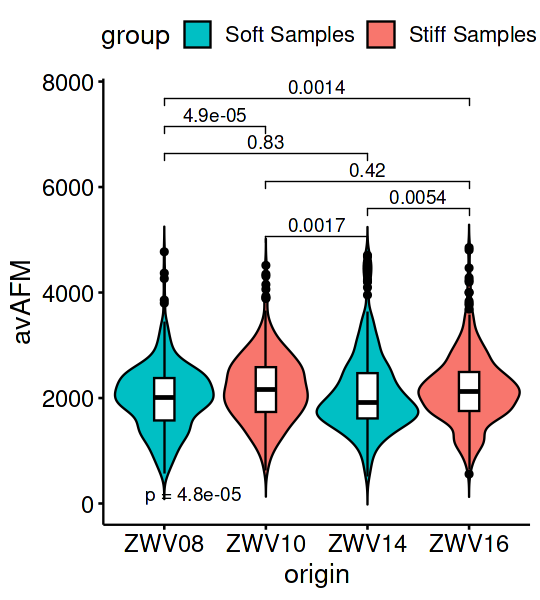

Warning message:
“Removed 9 rows containing missing values (`geom_signif()`).”


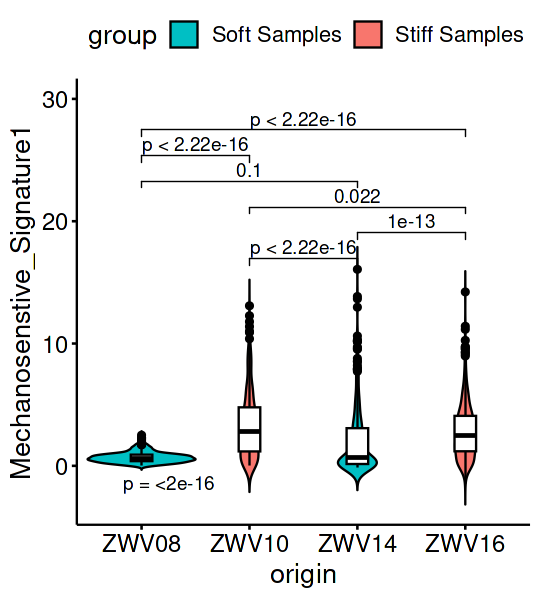

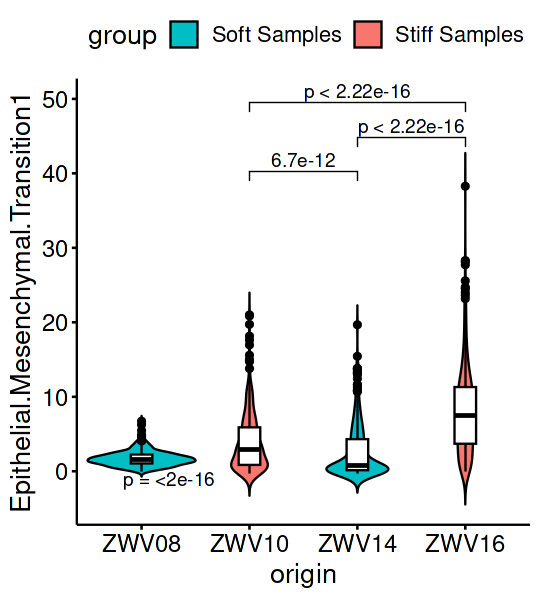

In [21]:
library(ggpubr)

options(repr.plot.width=NULL, repr.plot.height=NULL)

my_comparisons <- list( c("ZWV10", "ZWV14"), c("ZWV16", "ZWV14"), c("ZWV10", "ZWV16") ,
                      c("ZWV08", "ZWV14"), c("ZWV10", "ZWV08"), c("ZWV08", "ZWV16"))

metadata_list <- lapply(spatial.AFM, function(x) {
  x@meta.data
})

# Combine the metadata into a single dataframe
combined_metadata <- bind_rows(metadata_list)
combined_metadata$group <- ifelse(combined_metadata$origin %in% c("ZWV08", "ZWV14"), "Soft Samples", "Stiff Samples")

# Define custom colors for the groups
custom_colors <- c("Soft Samples" = "#00bfc4", "Stiff Samples" = "#f8766d")

# Display the combined metadata
# Adjust plot dimensions (narrower plot)
options(repr.plot.width=4.5, repr.plot.height=5)  # Adjust width and height accordingly

ggviolin(combined_metadata, x = "origin", y = "avAFM",
         add = "boxplot", fill = "group", color = "black", palette = custom_colors, 
         add.params = list(fill = "white", color = "black")) +  # Black outlines for boxplot
  stat_compare_means(comparisons = my_comparisons, label = "p.adj") +  # Add pairwise significance levels
  stat_compare_means(method = "kruskal.test", label = "p", label.x = 1, label.y = 55) +  # Add Kruskal-Wallis test result
  theme(text = element_text(size = 16),  # Increase font size
        axis.text = element_text(size = 14),
        axis.title = element_text(size = 16))

# Fill the violin plots, add black outlines, and leave the boxplot white with black outlines
ggviolin(combined_metadata, x = "origin", y = "Mechanosenstive_Signature1",
         add = "boxplot", fill = "group", color = "black", palette = custom_colors, 
         add.params = list(fill = "white", color = "black")) +  # Black outlines for boxplot
  stat_compare_means(comparisons = my_comparisons, label = "p.adj") +  # Add pairwise significance levels
  stat_compare_means(method = "kruskal.test", label = "p", label.x = 1, label.y = -2) +  # Add Kruskal-Wallis test result
  ylim(NA, 30) +  # Set maximum y-axis limit to 35
  theme(text = element_text(size = 16),  # Increase font size
        axis.text = element_text(size = 14),
        axis.title = element_text(size = 16))


ggviolin(combined_metadata, x = "origin", y = "Epithelial.Mesenchymal.Transition1",
         add = "boxplot", fill = "group", color = "black", palette = custom_colors, 
         add.params = list(fill = "white", color = "black")) +  # Black outlines for boxplot
  stat_compare_means(comparisons = my_comparisons, label = "p.adj") +  # Add pairwise significance levels
  stat_compare_means(method = "kruskal.test", label = "p", label.x = 1, label.y = -2) + 
  ylim(NA, 50) +  # Set maximum y-axis limit to 35 # Add Kruskal-Wallis test result
  theme(text = element_text(size = 16),  # Increase font size
        axis.text = element_text(size = 14),
        axis.title = element_text(size = 16))



In [23]:
# Specify the file name and open the PDF device
pdf("my_violin_plots.pdf", width = 4.5, height = 5)  # Adjust width and height as needed
#options(repr.plot.width=, repr.plot.height=5)  # Adjust width and height accordingly

# First plot: avAFM
ggviolin(combined_metadata, x = "origin", y = "avAFM",
         add = "boxplot", fill = "group", color = "black", palette = custom_colors, 
         add.params = list(fill = "white", color = "black")) +  # Black outlines for boxplot
  stat_compare_means(comparisons = my_comparisons, label = "p.adj") +  # Add pairwise significance levels
  stat_compare_means(method = "kruskal.test", label = "p", label.x = 1, label.y = 55) +  # Add Kruskal-Wallis test result
  theme(text = element_text(size = 16),  # Increase font size
        axis.text = element_text(size = 14),
        axis.title = element_text(size = 16))

# Second plot: Mechanosenstive_Signature1
filtered_metadata1 <- combined_metadata %>% 
  filter(Mechanosenstive_Signature1 <= 12)

ggviolin(filtered_metadata1, x = "origin", y = "Mechanosenstive_Signature1",
         add = "boxplot", fill = "group", color = "black", palette = custom_colors, 
         add.params = list(fill = "white", color = "black")) +  # Black outlines for boxplot
  stat_compare_means(comparisons = my_comparisons, label = "p.adj") +  # Add pairwise significance levels
  ylim(NA, 20) +  # Set maximum y-axis limit
  theme(text = element_text(size = 16),  # Increase font size
        axis.text = element_text(size = 14),
        axis.title = element_text(size = 16))

# Third plot: Epithelial.Mesenchymal.Transition1
filtered_metadata2 <- combined_metadata %>% 
  filter(Epithelial.Mesenchymal.Transition1 <= 25)

ggviolin(filtered_metadata2, x = "origin", y = "Epithelial.Mesenchymal.Transition1",
         add = "boxplot", fill = "group", color = "black", palette = custom_colors, 
         add.params = list(fill = "white", color = "black")) +  # Black outlines for boxplot
  stat_compare_means(comparisons = my_comparisons, label = "p.adj") +  # Add pairwise significance levels
  ylim(NA, 40) +  # Set maximum y-axis limit
  theme(text = element_text(size = 16),  # Increase font size
        axis.text = element_text(size = 14),
        axis.title = element_text(size = 16))

# Close the PDF device
dev.off()


Warning message:
“Removed 3 rows containing missing values (`geom_signif()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_signif()`).”


png 
  2

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,percent.rps,percent.rpl,percent.rp,predicted_doublets,doublet_scores,nCount_SCT,⋯,Positive.Regulation.Of.Angiogenesis..GO.0045766.1,Positive.Regulation.Of.Vasculature.Development..GO.1904018.1,Regulation.Of.Vascular.Endothelial.Growth.Factor.Production..GO.0010574.1,Epithelial.To.Mesenchymal.Transition..GO.0001837.1,Hypoxia1,mTORC1.Signaling1,Angiogenesis1,IL.2.STAT5.Signaling1,RNA_snn_res.15,Source
,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
Du13_TGGGAAGTCGGTCTAA-1,Du13,18129,5368,9.972971,0.2261570,0.29234927,0.5185063,FALSE,0.2480418,1116,⋯,0.08614653,0.09113780,-0.05723134,-0.0000588046,0.17794397,0.061757254,0.081137237,0.06174415,3,ZWV08
Du13_GCGCGATAGTTAACGA-1,Du13,16059,4944,2.360047,0.2428545,0.15567594,0.3985304,FALSE,0.4915254,1167,⋯,0.01713840,0.01878885,0.09513647,0.0097382644,0.09171096,0.032916504,-0.102719927,0.05134807,11,ZWV08
Du13_TAAGTGCAGCCAGTAG-1,Du13,14621,4447,4.514055,0.2735791,0.12995007,0.4035292,FALSE,0.4732510,1289,⋯,0.07086431,0.07263470,-0.03498314,-0.0174575905,0.10328324,0.007713451,0.103178657,0.05702529,2,ZWV08
Du13_ATGTGTGTCTTGAGGT-1,Du13,14461,4591,1.196321,0.3042666,0.15904848,0.4633151,FALSE,0.2873563,1161,⋯,0.03137541,0.01644112,-0.01754864,-0.0035256706,0.10507512,-0.002408687,-0.007554023,0.01330143,65,ZWV08
Du13_ACCAGTAGTCTAGGTT-1,Du13,13872,4371,1.398501,0.2595156,0.06487889,0.3243945,FALSE,0.3698630,1192,⋯,-0.02624798,-0.02173537,0.15581711,-0.0006139623,0.05870472,-0.034060071,-0.027110150,0.02521602,51,ZWV08
Du13_GACCAATAGAAAGTGG-1,Du13,13463,4569,2.458590,0.2822551,0.31196613,0.5942212,FALSE,0.3824561,1222,⋯,0.08000490,0.08651276,0.06167616,0.0772117620,0.13867032,0.081213482,0.045694359,0.05267372,22,ZWV08


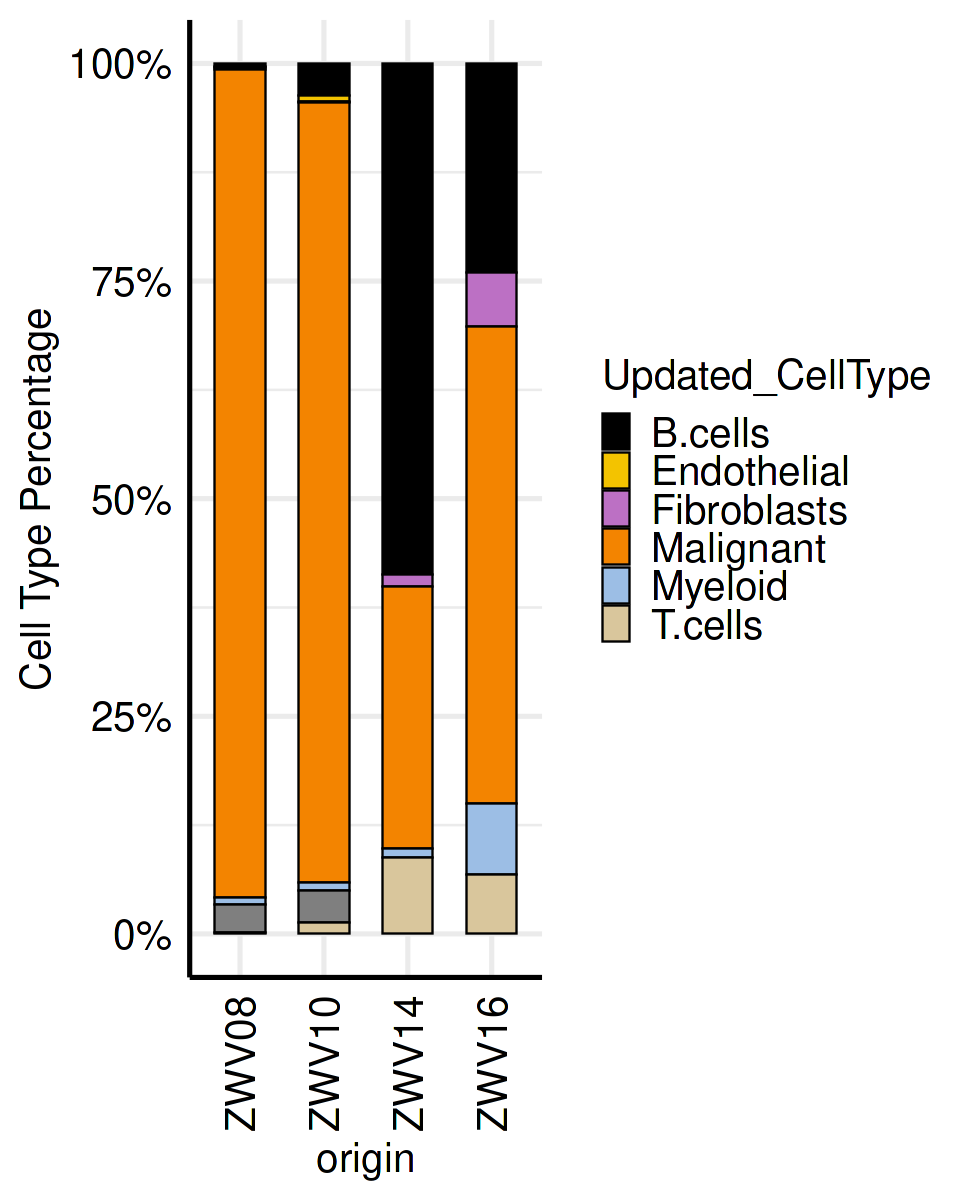

In [27]:


# Initialize an empty data frame to store combined metadata
combined_metadata <- data.frame()

# Loop through each Seurat object in the list
for(i in 1:length(scRNA.AFM)) {
  # Extract metadata
  metadata <- scRNA.AFM[[i]][[]]

  # Assuming 'MajorGroups_v2' is in the metadata, add it to the combined data frame
  if("Updated_CellType" %in% colnames(metadata)) {
    # Optionally add a column to identify the source Seurat object if needed
    metadata$Source <- samples[[i]]
    combined_metadata <- rbind(combined_metadata, metadata)
  }
}

# Check the first few rows of the combined metadata
head(combined_metadata)
cell_counts <- combined_metadata %>%
  group_by(Source, Updated_CellType) %>%
  summarise(Count = n(), .groups = 'drop')

# View the structure to confirm it's correct
total_counts <- cell_counts %>%
  group_by(Source) %>%
  summarise(Total = sum(Count))

# Join the counts back to the original data to calculate percentages
percentage_data <- cell_counts %>%
  left_join(total_counts, by = "Source") %>%
  mutate(Percentage = Count / Total) %>%
  select(Source, Updated_CellType, Percentage)


percentage_data$MajorGroups_v2 <- factor(percentage_data$Updated_CellType, levels = c("Malignant", "T_cells", "B_cells", "Fibroblasts", "Endothelial", "Other","Myeloid"))

cell_types_with_colors <- c("B.cells", "Endothelial", "Fibroblasts", "Malignant", "Myeloid", "Other", "T.cells")
colors <- c("#000000", "#f3c300", "#bc70c4", "#f38400", "#9cbee5", "#d72828", "#d9c69c")
celltype_colors <- setNames(colors, cell_types_with_colors)


options(repr.plot.width=8, repr.plot.height=10)

ggplot(percentage_data, aes(x = Source, y = Percentage, fill = Updated_CellType)) +
  geom_bar(stat = "identity", position = "fill", width = 0.6, color = "black") +  # Adjust bar width and add black border
  scale_y_continuous(labels = scales::percent_format()) +  # Format y-axis labels as percentages
  scale_fill_manual(values = celltype_colors) +  # Use the custom colors
  theme_minimal(base_size = 24) +  # Set the base font size to 24
  labs(x = "origin", y = "Cell Type Percentage") +
  theme(
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1, size = 24, color = "black"),  # Adjust x-axis text angle and size
    axis.text.y = element_text(size = 24, color = "black"),  # Adjust y-axis text size
    axis.title.x = element_text(size = 24, color = "black"),  # Adjust x-axis title size
    axis.title.y = element_text(size = 24, color = "black"),  # Adjust y-axis title size
    plot.title = element_text(size = 24, face = "bold"),  # Adjust title size and make bold
    legend.text = element_text(size = 24, color = "black"),  # Adjust legend text size
    legend.title = element_text(size = 24, color = "black"),  # Adjust legend title size
    axis.line = element_line(color = "black")  # Make both x and y axis lines black
  )



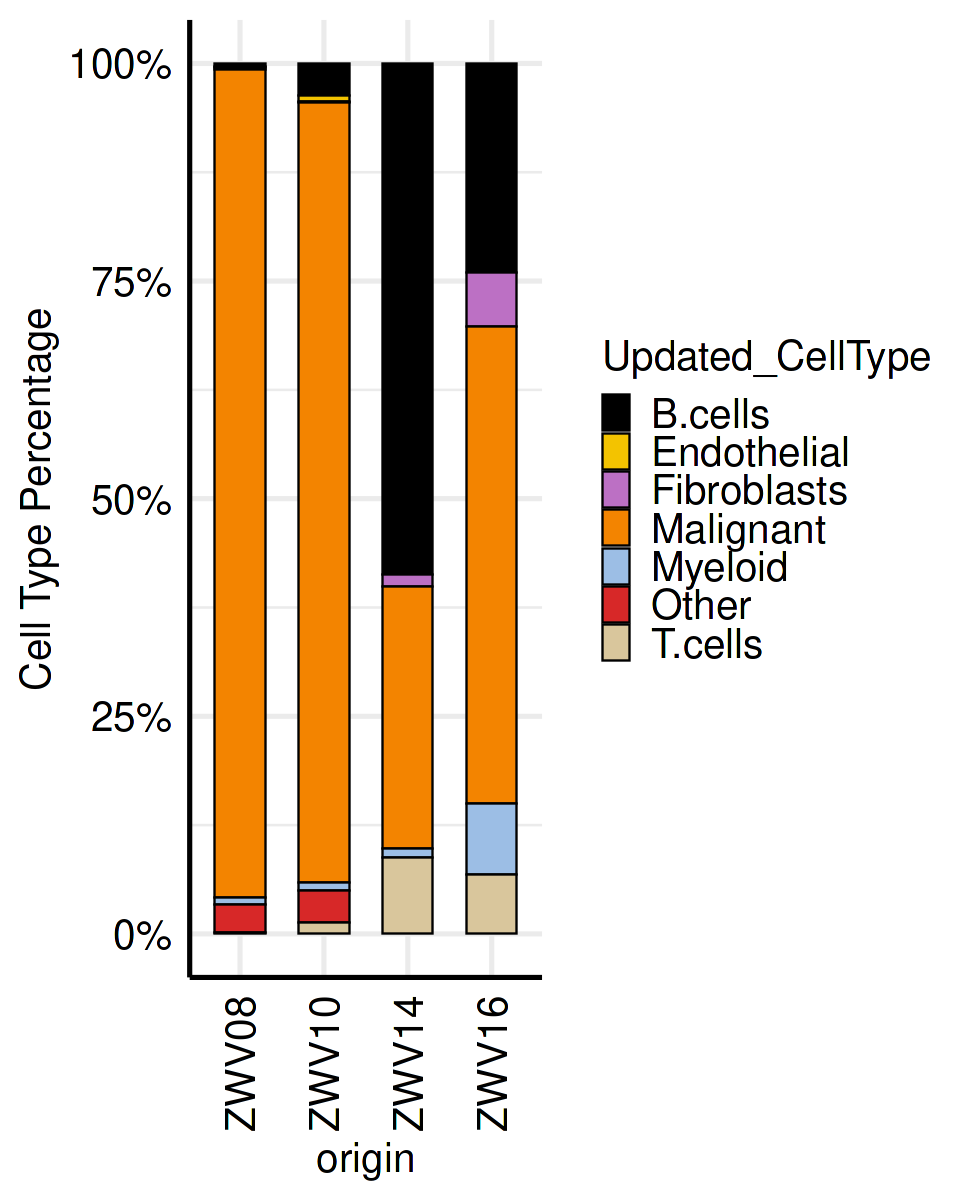

In [28]:
# Rename 'Nonmalignant.others' to 'Other'
percentage_data <- percentage_data %>%
  mutate(Updated_CellType = ifelse(Updated_CellType == "Nonmalignant.others", "Other", Updated_CellType))

# Ensure the updated levels are used for the plot
percentage_data$MajorGroups_v2 <- factor(percentage_data$Updated_CellType, 
                                         levels = c("Malignant", "T_cells", "B_cells", 
                                                    "Fibroblasts", "Endothelial", "Other", "Myeloid"))

# Plot with the renamed category
bar_plot <- ggplot(percentage_data, aes(x = Source, y = Percentage, fill = Updated_CellType)) +
  geom_bar(stat = "identity", position = "fill", width = 0.6, color = "black") +  # Adjust bar width and add black border
  scale_y_continuous(labels = scales::percent_format()) +  # Format y-axis labels as percentages
  scale_fill_manual(values = celltype_colors) +  # Use the custom colors
  theme_minimal(base_size = 24) +  # Set the base font size to 24
  labs(x = "origin", y = "Cell Type Percentage") +
  theme(
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1, size = 24, color = "black"),  # Adjust x-axis text angle and size
    axis.text.y = element_text(size = 24, color = "black"),  # Adjust y-axis text size
    axis.title.x = element_text(size = 24, color = "black"),  # Adjust x-axis title size
    axis.title.y = element_text(size = 24, color = "black"),  # Adjust y-axis title size
    plot.title = element_text(size = 24, face = "bold"),  # Adjust title size and make bold
    legend.text = element_text(size = 24, color = "black"),  # Adjust legend text size
    legend.title = element_text(size = 24, color = "black"),  # Adjust legend title size
    axis.line = element_line(color = "black")  # Make both x and y axis lines black
  )
bar_plot

In [30]:
pdf_file <- "bar_plot.pdf"

# Save with specified dimensions (in inches)
ggsave(filename = pdf_file, 
       plot = bar_plot, 
       device = "pdf", 
       width = 8, 
       height = 10)

# Confirm save location
cat("Bar plot saved to", pdf_file, "\n")


Bar plot saved to bar_plot.pdf 


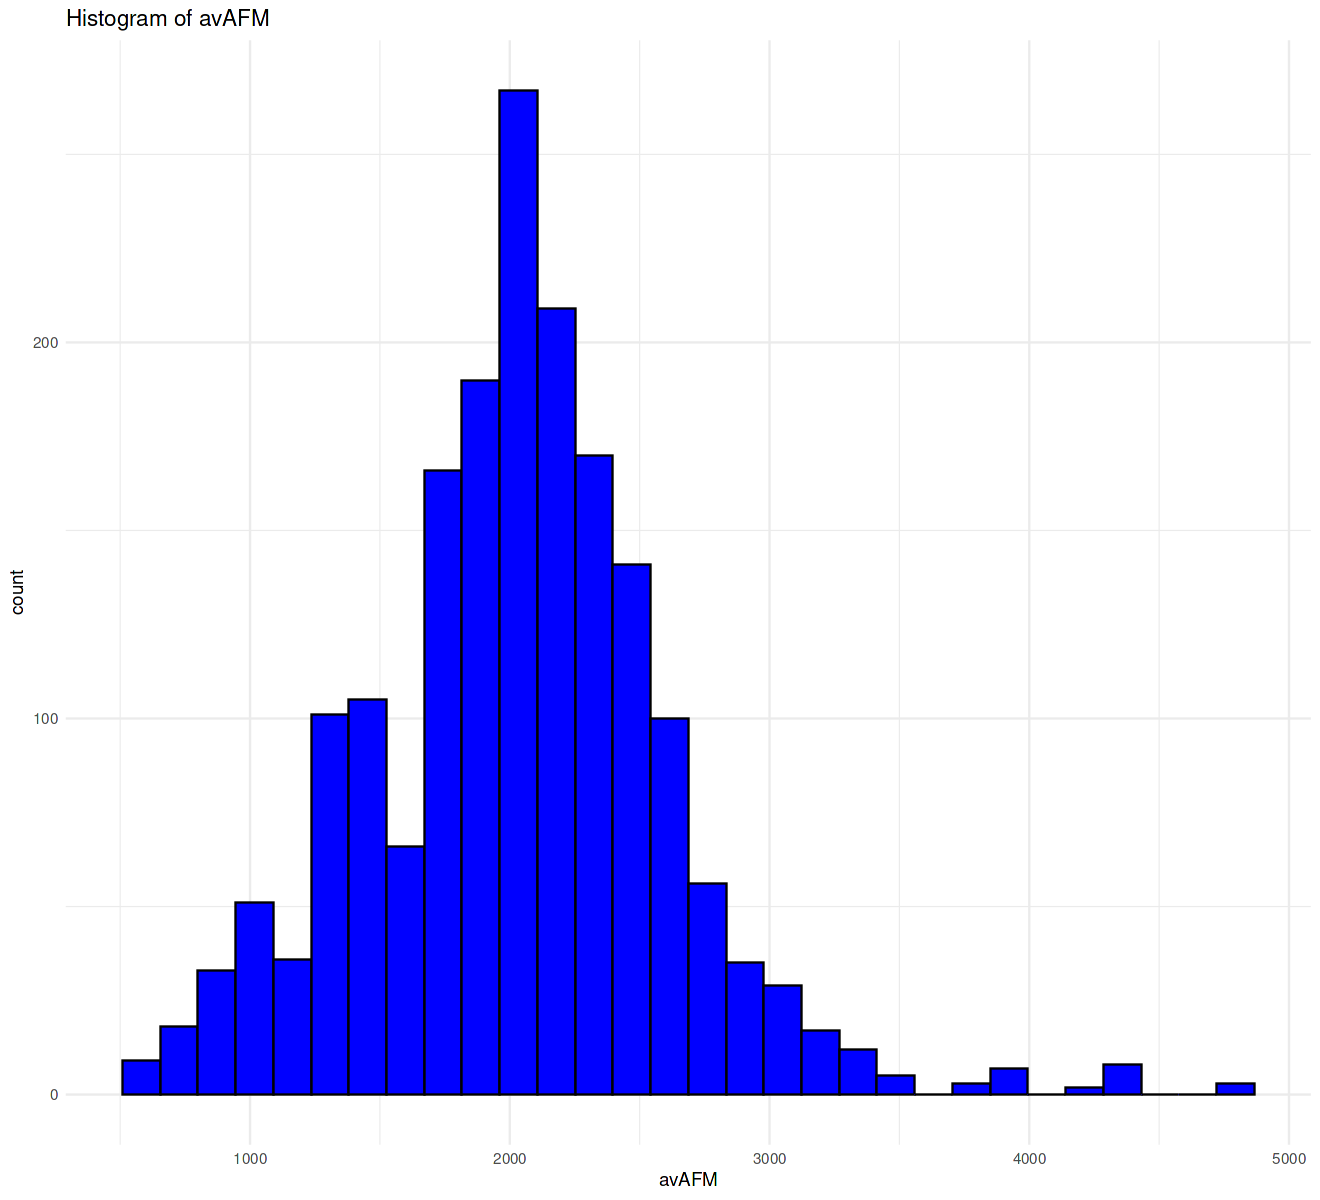

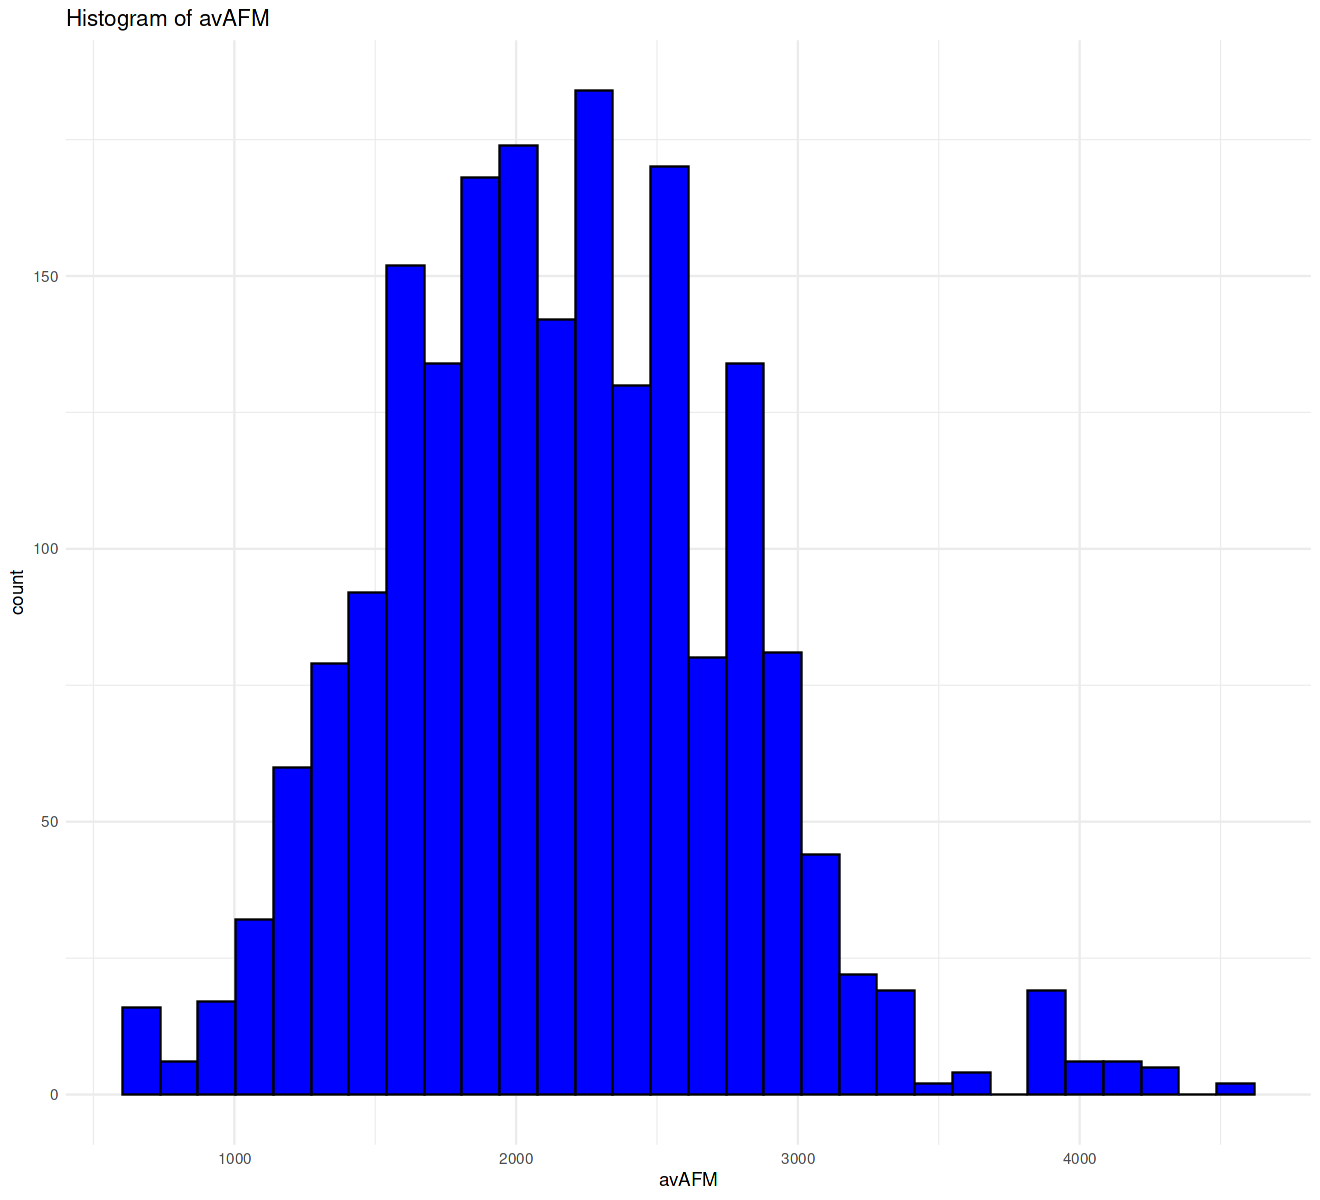

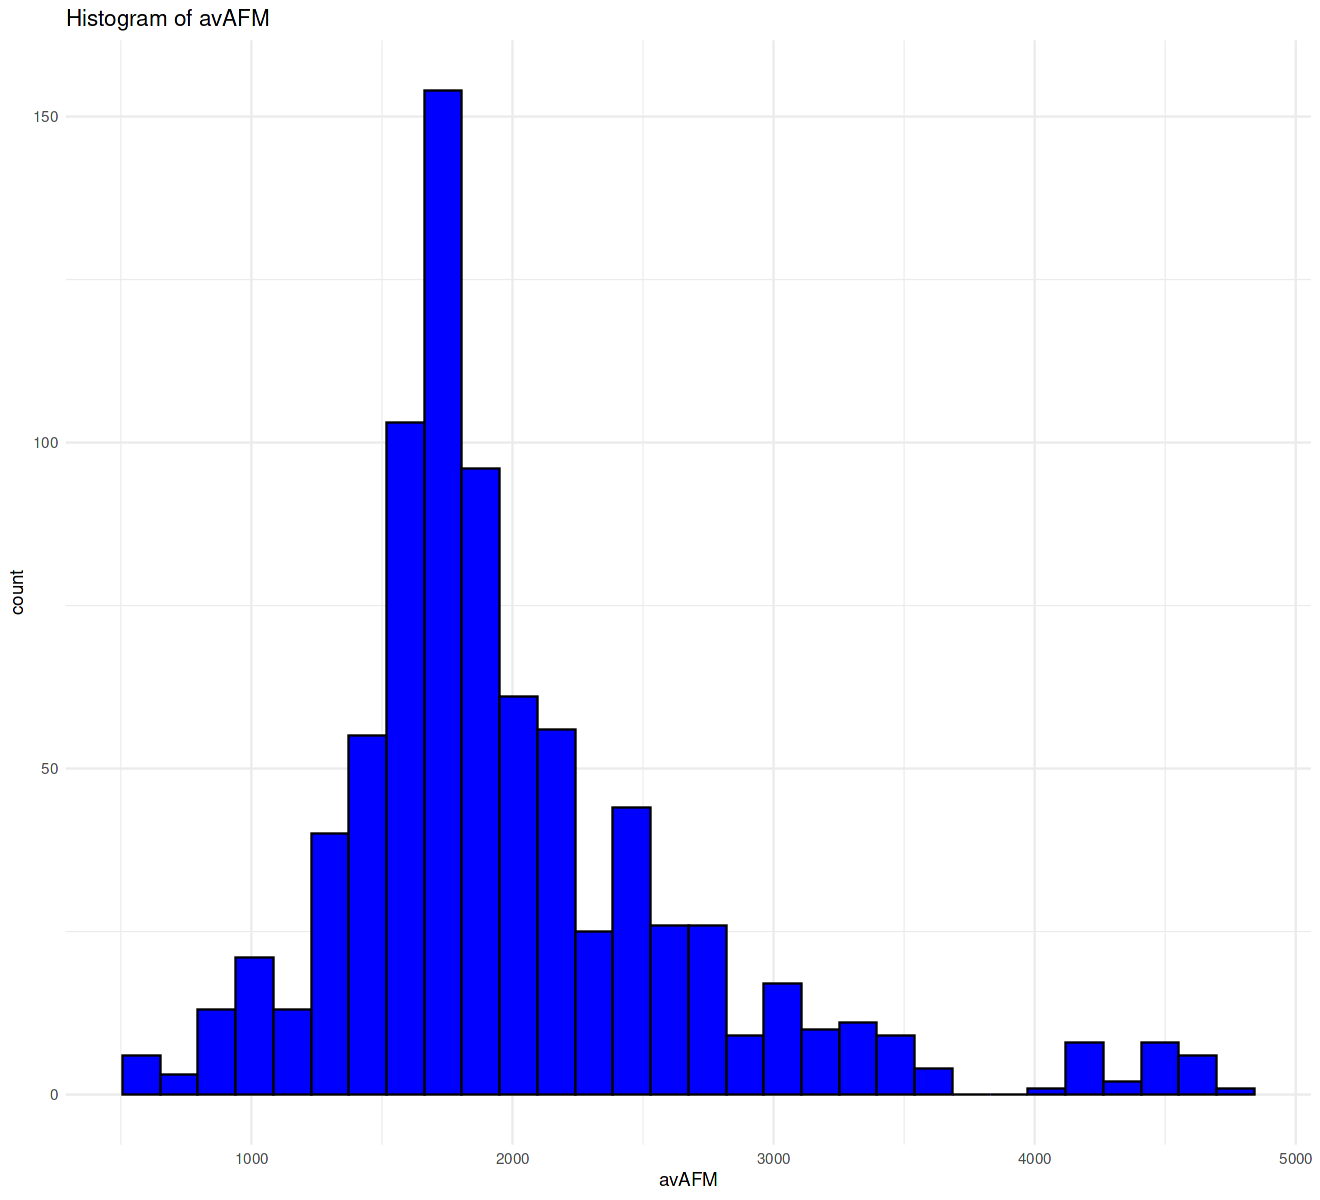

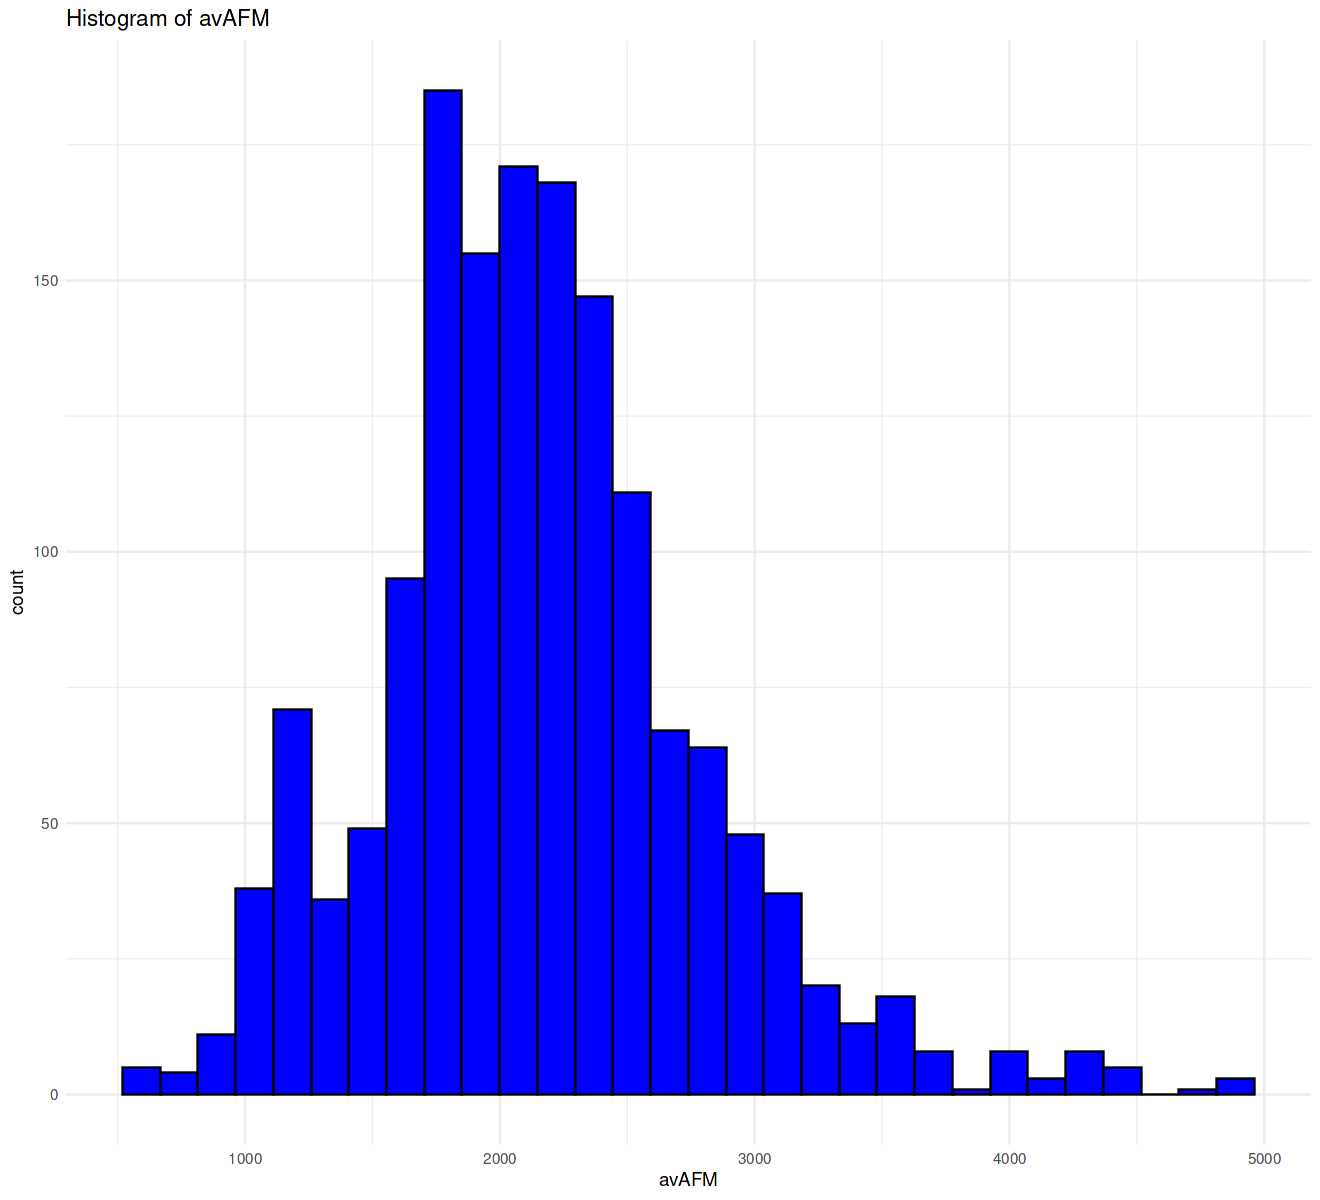

In [32]:
library(ggplot2)

# Create a list of ggplot objects, each being a histogram of the avAFM column
histograms <- lapply(scRNA.AFM, function(df) {
  ggplot(df@meta.data, aes(x = avAFM)) +
    geom_histogram(bins = 30, fill = "blue", color = "black") +
    theme_minimal() +
    ggtitle("Histogram of avAFM")
})

# Print the histograms
# If you are running this in an interactive R session (like RStudio), you can view them one by one

  for (plot in histograms) {
    print(plot)
  }



In [6]:
sc_metadata_list <- lapply(scRNA.AFM, function(x) {
  x@meta.data
})
sc_combined_metadata <- bind_rows(sc_metadata_list)



all_afm_scRNA <- subset(durva, subset = CellName %in% rownames(sc_combined_metadata) )

all_afm_scRNA@meta.data$avAFM <- sc_combined_metadata$avAFM[match(rownames(all_afm_scRNA@meta.data), rownames(sc_combined_metadata))]

all_afm_scRNA@meta.data$Epithelial.Mesenchymal.Transition1 <- sc_combined_metadata$Epithelial.Mesenchymal.Transition1[match(rownames(all_afm_scRNA@meta.data), rownames(sc_combined_metadata))]

all_afm_scRNA@meta.data$Mechanosenstive_Signature1 <- sc_combined_metadata$Mechanosenstive_Signature1[match(rownames(all_afm_scRNA@meta.data), rownames(sc_combined_metadata))]

for (col_name in colnames(sc_combined_metadata)[grep("1$", colnames(sc_combined_metadata))]) {
  # Create a new column in all_afm_scRNA@meta.data with the same name
  all_afm_scRNA@meta.data[[col_name]] <- sc_combined_metadata[[col_name]][match(rownames(all_afm_scRNA@meta.data), rownames(sc_combined_metadata))]
}

malig_only <- subset(all_afm_scRNA, subset = Updated_CellType == "Malignant" )

all_afm_scRNA <- RunPCA(all_afm_scRNA)
all_afm_scRNA <- FindNeighbors(all_afm_scRNA, dims = 1:10)
all_afm_scRNA <- FindClusters(all_afm_scRNA, resolution = 0.5)
all_afm_scRNA <- RunUMAP(all_afm_scRNA, dims = 1:10)

malig_only <- RunPCA(malig_only)
malig_only <- FindNeighbors(malig_only, dims = 1:10)
malig_only <- FindClusters(malig_only, resolution = 0.5)
malig_only <- RunUMAP(malig_only, dims = 1:10)



PC_ 1 
Positive:  MIR100HG, EFNA5, PARD3, ERRFI1, MECOM, F3, CHL1, SGMS2, PHACTR3, GLIS3 
	   WWTR1, SFTPB, NEDD4L, EDN2, RBMS3, SDK1, GPRC5A, PID1, LMO7, NEBL 
	   OSMR, LIMCH1, PTCHD4, MACROD2, TANC2, CYP4B1, MAGI1, SHROOM3, ANXA2, TCIM 
Negative:  SAMSN1, PDE4B, B2M, IGHG1, MARCH1, BLK, SRGN, FCRL5, WDFY4, IGKC 
	   POU2AF1, FYB1, AOAH, ZEB2, HLA-DRA, TFEC, IL7R, PIM2, CEP128, LRMP 
	   THEMIS, MS4A1, IGHGP, CYBB, SLC7A5, SSPN, IRF8, FCRL1, FAR2, PAX5 
PC_ 2 
Positive:  LAMA2, CACNA1C, CRISPLD2, COL6A3, SERPINE1, COL4A1, SCN7A, LSAMP, MMP19, ABI3BP 
	   PDZRN3, COL4A2, COL5A2, NAV3, PDGFRA, COL1A2, CALD1, FBN1, PDLIM3, SGIP1 
	   ROBO2, TENM3, COL3A1, UNC5C, PRR16, SLIT2, GFPT2, CCN4, ANK2, FSTL1 
Negative:  SFTPB, SGMS2, SLC34A2, NEDD4L, ROS1, F3, CYP4B1, ALPL, CD55, CTSE 
	   SYN3, HOPX, AGBL1, AC044810.2, P3H2, TMC5, SFTPA2, SFTPA1, CDH1, ARFGEF3 
	   BPIFB1, PHACTR3, KRT7, RIMS1, STEAP4, MACC1, LMO7, ZNF385B, EDN2, MGST1 
PC_ 3 
Positive:  SLC1A3, MRC1, EPB41L3, CD163, SLC8A1, K

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6197
Number of edges: 198256

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9175
Number of communities: 19
Elapsed time: 0 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
23:33:29 UMAP embedding parameters a = 0.9922 b = 1.112

23:33:29 Read 6197 rows and found 10 numeric columns

23:33:29 Using Annoy for neighbor search, n_neighbors = 30

23:33:29 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

23:33:29 Writing NN index file to temp file /tmp/Rtmp3z17d8/file4aa4fbd43c6

23:33:29 Searching Annoy index using 1 thread, search_k = 3000

23:33:32 Annoy recall = 100%

23:33:32 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4623
Number of edges: 145319

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9027
Number of communities: 12
Elapsed time: 0 seconds


23:33:48 UMAP embedding parameters a = 0.9922 b = 1.112

23:33:48 Read 4623 rows and found 10 numeric columns

23:33:48 Using Annoy for neighbor search, n_neighbors = 30

23:33:48 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

23:33:49 Writing NN index file to temp file /tmp/Rtmp3z17d8/file4aa4a20aabe

23:33:49 Searching Annoy index using 1 thread, search_k = 3000

23:33:51 Annoy recall = 100%

23:33:51 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

23:33:53 Initializing from normalized Laplacian + noise (using irlba)

23:33:53 Commencing optimization for 500 epochs, with 188628 positive edges

23:33:59 Optimization finished



In [ ]:
malig_only <- RunPCA(malig_only)
malig_only <- FindNeighbors(malig_only, dims = 1:10)
malig_only <- FindClusters(malig_only, resolution = 0.5)
malig_only <- RunUMAP(malig_only, dims = 1:10)


In [34]:
non_malig <- subset(all_afm_scRNA, subset = Malignant_NonMalignant_v2 == "Non_malignant" )


In [58]:
write.csv(all_afm_scRNA@meta.data, "integrated_data/all_cell_metadata_reint_new_class.csv")

In [59]:
non_malig@meta.data$Malignant_NonMalignant_v2
non_malig <- RunPCA(non_malig)
non_malig <- FindNeighbors(non_malig, dims = 1:10)
non_malig <- FindClusters(non_malig, resolution = 10)
non_malig <- RunUMAP(non_malig, dims = 1:10)


[1] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
   [5] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
   [9] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
  [13] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
  [17] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
  [21] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
  [25] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
  [29] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
  [33] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
  [37] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
  [41] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
  [45] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
  [49] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
  [53] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
  [57] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
  [61] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
  [65] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
  [69] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
  [73] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
  [77] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
  [81] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
  [85] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
  [89] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
  [93] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
  [97] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
 [101] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
 [105] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
 [109] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
 [113] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
 [117] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
 [121] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
 [125] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
 [129] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
 [133] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
 [137] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
 [141] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
 [145] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
 [149] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
 [153] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
 [157] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
 [161] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
 [165] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
 [169] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
 [173] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
 [177] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
 [181] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
 [185] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
 [189] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
 [193] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
 [197] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
 [201] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
 [205] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
 [209] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
 [213] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
 [217] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
 [221] "Non_malignant" "Non_malignant" "Non_malignant" "Non_malignant"
 [225] "Non_malignant" "Non

PC_ 1 
Positive:  RFX2, TANC2, FOSB, ANXA2, MIR100HG, SDK1, SFTPB, ERRFI1, TIPARP, PARD3B 
	   RBMS3, PID1, PARD3, SGMS2, NAMPT, LIMCH1, MECOM, WWTR1, EFNA5, GLIS3 
	   IL1R1, PTPRE, GPRC5A, VEGFA, CD9, AASS, F3, NFIB, CHL1, MACROD2 
Negative:  BLK, MS4A1, BANK1, FCRL1, EBF1, PAX5, POU2AF1, FCRL5, MARCH1, STAP1 
	   SSPN, AL592429.2, PIM2, MZB1, WDFY4, IGHM, TP53INP1, AFF3, COL19A1, AC120193.1 
	   IRF8, IGKC, CLNK, CD83, BCL11A, FAM30A, TXNDC5, RPLP1, CEP128, BACH2 
PC_ 2 
Positive:  SSR4, FTL, RPL3, TPT1, IGHGP, S100A6, MIF, RPL8, RPS18, IGKC 
	   RPLP1, IGHG2, XBP1, S100A11, RPL10, RPL19, RPS23, DNAAF1, RPS12, IGHG1 
	   DERL3, PIM2, RPS15, EEF1A1, RPS6, RPL13, MT-ND5, RPS19, HSPA5, TXNDC5 
Negative:  MKI67, DIAPH3, KIF23, BUB1B, GTSE1, NCAPG, ANLN, ASPM, KIF18B, RRM2 
	   KIF11, NUSAP1, CENPF, ARHGAP11B, KNL1, NEIL3, MELK, CENPE, CDCA2, HELLS 
	   POLQ, TOP2A, CENPP, DTL, CENPI, LINC01572, BRIP1, EZH2, BUB1, TPX2 
PC_ 3 
Positive:  TP53INP1, ITGA6, FCRL5, MERTK, AC002072.1, DNAAF1,

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2011
Number of edges: 62064

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.4774
Number of communities: 47
Elapsed time: 0 seconds


00:01:00 UMAP embedding parameters a = 0.9922 b = 1.112

00:01:00 Read 2011 rows and found 10 numeric columns

00:01:00 Using Annoy for neighbor search, n_neighbors = 30

00:01:00 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

00:01:01 Writing NN index file to temp file /tmp/RtmpzubsUF/file26675019ab83

00:01:01 Searching Annoy index using 1 thread, search_k = 3000

00:01:01 Annoy recall = 100%

00:01:02 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

00:01:03 Initializing from normalized Laplacian + noise (using irlba)

00:01:03 Commencing optimization for 500 epochs, with 77712 positive edges

00:01:06 Optimization finished



In [8]:
unique(all_afm_scRNA@meta.data$Updated_CellType)

[1] "Malignant"           "Fibroblasts"         "B.cells"            
[4] "Nonmalignant.others" "Myeloid"             "T.cells"            
[7] "Endothelial"

In [9]:

t_cells <- subset(all_afm_scRNA, subset = Updated_CellType == "T.cells")
t_cells <- RunPCA(t_cells)
t_cells <- FindNeighbors(t_cells, dims = 1:10)
t_cells <- FindClusters(t_cells, resolution = 0.5)
t_cells <- RunUMAP(t_cells, dims = 1:10)
saveRDS(t_cells, "integrated_data/t_cells_reint_newclass.rds")


saveRDS(t_cells, "~/t_cells/human_durva.rds")

PC_ 1 
Positive:  THEMIS, IL7R, LINC01934, FYB1, NELL2, INPP4B, DTHD1, AL136456.1, AOAH, TNFAIP3 
	   ST8SIA1, AC139720.1, MYBL1, CCL5, LEF1, SAMSN1, PLCB1, TAFA1, SRGN, NCALD 
	   LINC02694, AF165147.1, MIR3142HG, KLRC2, CRTAM, TNIP3, BACH2, ANK3, ADAM23, AL392086.3 
Negative:  RAB31, PELI1, RFX2, CCSER1, ALCAM, SOX5, FOSB, SFTPB, ANXA2, TANC2 
	   TMEM163, MIR100HG, FMNL2, PTPRK, NEDD4L, NAMPT, VEGFA, TCF4, FAM13A, SLC22A23 
	   ERRFI1, F3, SAMD4A, PARD3, LTF, MECOM, CD9, SVIL, PTPRG, WWTR1 
PC_ 2 
Positive:  AOAH, MYBL1, DTHD1, TPRG1, CRTAM, PLCB1, KLRC2, AUTS2, EPHA4, AL392086.3 
	   PDGFD, CCL5, PCAT1, TNIP3, KLRC1, AF165147.1, AC243829.2, IFNG-AS1, TENM1, ZEB2 
	   SLC4A4, PECAM1, ITGA1, THEMIS, SGCD, CDHR3, ST8SIA6, C1orf21, SPEF2, CCL4 
Negative:  AL136456.1, AC139720.1, GNG4, TSHZ2, RTKN2, LINC02694, PDE7B, CXCL13, TOX2, TAFA2 
	   MIR3142HG, PTPN13, ST6GALNAC3, IL12RB2, LINC01229, AC090125.1, LEF1, ZEB1, AL138720.1, GRAMD1B 
	   LINC02099, CSGALNACT1, COL5A3, BTBD11, ENOX1, C

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 207
Number of edges: 6554

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6910
Number of communities: 3
Elapsed time: 0 seconds


23:35:24 UMAP embedding parameters a = 0.9922 b = 1.112

23:35:24 Read 207 rows and found 10 numeric columns

23:35:24 Using Annoy for neighbor search, n_neighbors = 30

23:35:24 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

23:35:24 Writing NN index file to temp file /tmp/Rtmp3z17d8/file4aa3573bd66

23:35:24 Searching Annoy index using 1 thread, search_k = 3000

23:35:24 Annoy recall = 100%

23:35:24 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

23:35:26 Initializing from normalized Laplacian + noise (using irlba)

23:35:26 Commencing optimization for 500 epochs, with 8052 positive edges

23:35:27 Optimization finished



In [12]:
saveRDS(t_cells, "~/t_cells/human_durva.rds")

In [35]:
myeloid_cells <- subset(all_afm_scRNA, subset = Updated_CellType == "Myeloid")

myeloid_cells <- RunPCA(myeloid_cells)
myeloid_cells <- FindNeighbors(myeloid_cells, dims = 1:10)
myeloid_cells <- FindClusters(myeloid_cells, resolution = 0.5)
myeloid_cells <- RunUMAP(myeloid_cells, dims = 1:10)
saveRDS(myeloid_cells, "integrated_data/myeloid_cells_reint_newclassv2.rds")

PC_ 1 
Positive:  PDE4D, MIR100HG, SOX5, PARD3, RBMS3, ANK3, AC124276.2, MECOM, LTF, INPP4B 
	   MAGI3, CD55, MAST4, PTPRK, CCDC141, LMO7, SDK1, EFNA5, RBPMS, MAPK10 
	   MTUS1, CHL1, MYO1B, PDE10A, CYP4B1, MACROD2, BACH2, WWTR1, TCF7L1, TCIM 
Negative:  F13A1, STAB1, CD163, MRC1, SLCO2B1, MS4A6A, SLC1A3, IGSF21, KCNMA1, AL162414.1 
	   CLEC7A, IL2RA, CD86, CTSB, PLA2G7, AC100849.1, APOE, TLR2, C1QC, SLC8A1 
	   MSR1, EPB41L3, FRMD4A, SLC16A10, PSAP, FMN1, C1QB, CCL18, CD163L1, CD68 
PC_ 2 
Positive:  LYZ, GPNMB, APOE, CTSD, C1QA, CD68, FTL, C1QC, CXCL9, PSAP 
	   CST3, IFI30, SPARC, ENPP2, RARRES1, A2M, TPT1, CHIT1, C1QB, TMSB10 
	   CYBB, HLA-DRA, SELENOP, B2M, LPL, MT-CO3, ACTB, CD74, EEF1A1, CCL18 
Negative:  IGSF21, F13A1, AC100849.1, AL160272.1, MRC1, STAB1, RAB31, KCNMA1, PDK4, MERTK 
	   AL162414.1, MS4A4E, GAS7, CD163L1, TGFBI, PALD1, SLC16A10, SRGAP1, LNCAROD, ZNF331 
	   BNC2, SH3PXD2B, SDC2, ABCA1, IL2RA, DOCK4, FMN1, NAMPT, PDGFC, ATP8B4 
PC_ 3 
Positive:  F13A1, STAB1, CD

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 168
Number of edges: 4951

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7408
Number of communities: 3
Elapsed time: 0 seconds


21:09:02 UMAP embedding parameters a = 0.9922 b = 1.112

21:09:02 Read 168 rows and found 10 numeric columns

21:09:02 Using Annoy for neighbor search, n_neighbors = 30

21:09:02 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:09:03 Writing NN index file to temp file /tmp/Rtmp5RomMg/file1c3a74e43627

21:09:03 Searching Annoy index using 1 thread, search_k = 3000

21:09:03 Annoy recall = 100%

21:09:03 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

21:09:04 Initializing from normalized Laplacian + noise (using irlba)

21:09:04 Commencing optimization for 500 epochs, with 6356 positive edges

21:09:05 Optimization finished



In [36]:
all_afm_scRNA <- RunUMAP(all_afm_scRNA, dims = 1:10)

21:09:06 UMAP embedding parameters a = 0.9922 b = 1.112

21:09:06 Read 6197 rows and found 10 numeric columns

21:09:06 Using Annoy for neighbor search, n_neighbors = 30

21:09:06 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:09:07 Writing NN index file to temp file /tmp/Rtmp5RomMg/file1c3a23dc6190

21:09:07 Searching Annoy index using 1 thread, search_k = 3000

21:09:09 Annoy recall = 100%

21:09:10 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

21:09:11 Initializing from normalized Laplacian + noise (using irlba)

21:09:11 Commencing optimization for 500 epochs, with 252556 positive edges

21:09:19 Optimization finished



In [54]:
unique(all_afm_scRNA$Updated_CellType)

[1] "Malignant"           "Fibroblasts"         "B.cells"            
[4] "Nonmalignant.others" "Myeloid"             "T.cells"            
[7] "Endothelial"

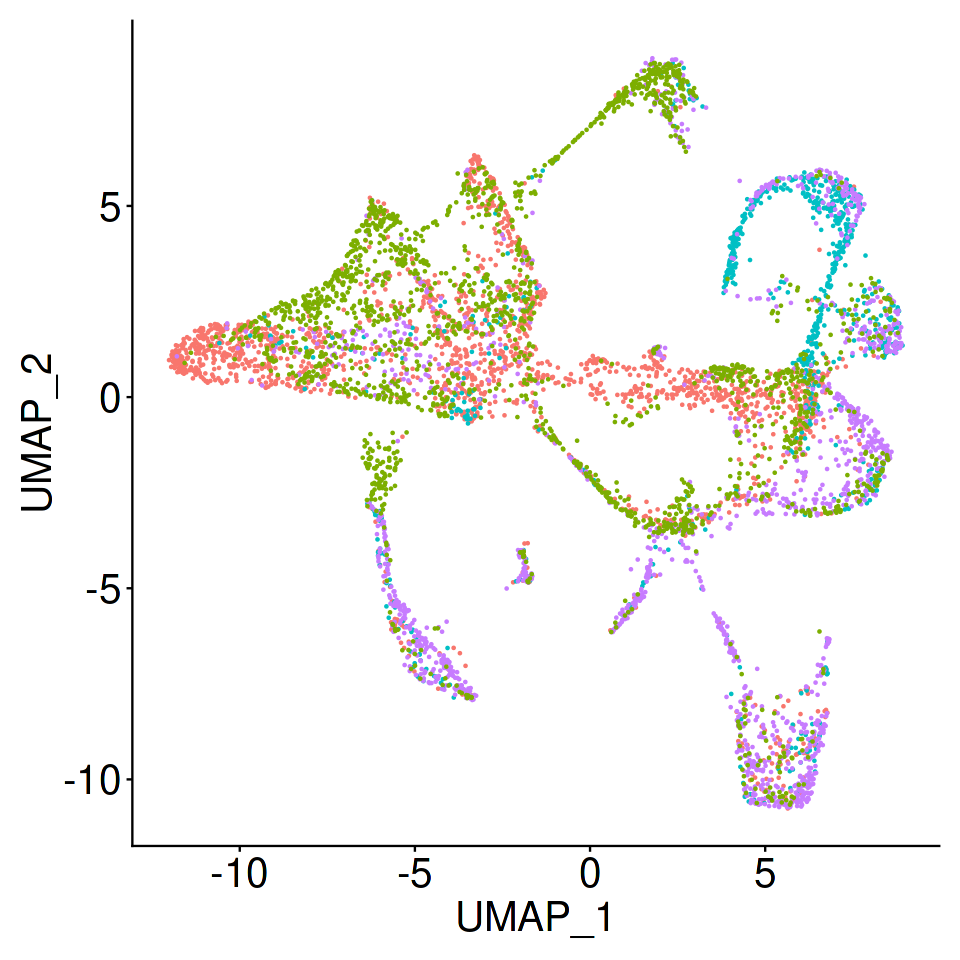

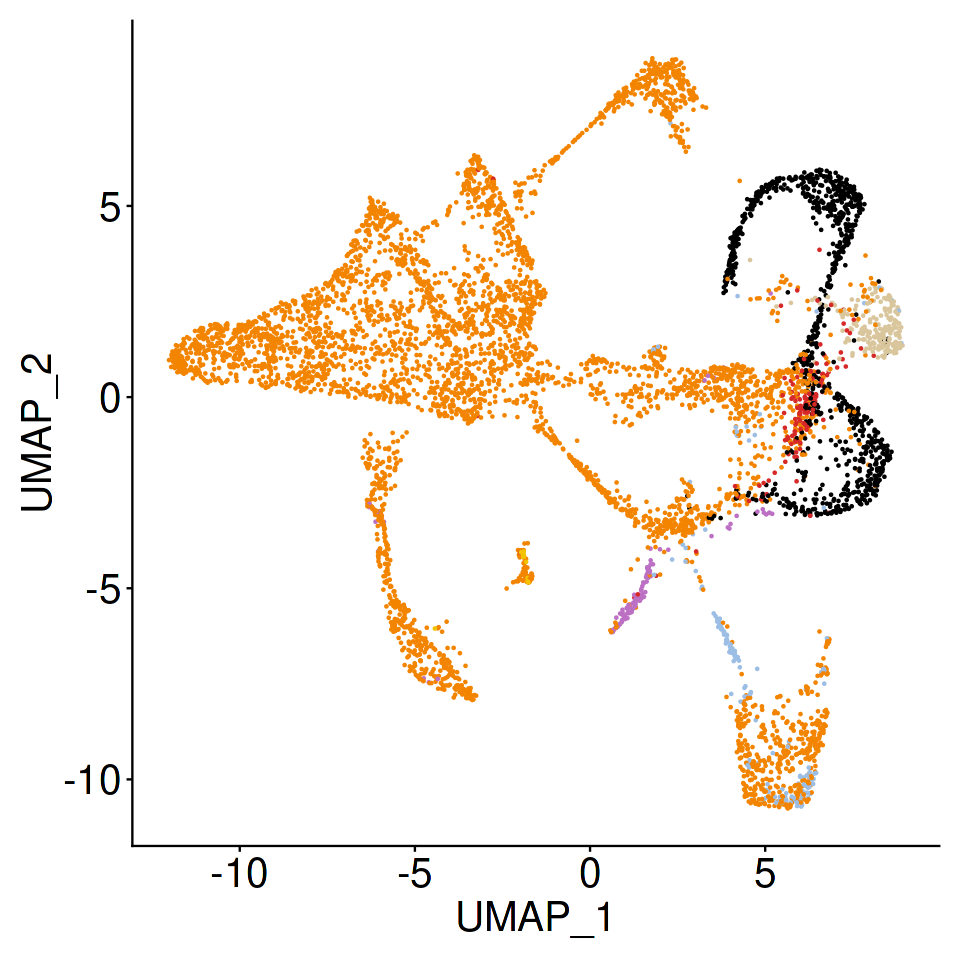

In [55]:
options(repr.plot.width = 8, repr.plot.height = 8)


cell_types_with_colors <- c("B.cells", "Endothelial", "Fibroblasts", "Malignant", "Myeloid", "Nonmalignant.others", "T.cells")
colors <- c("#000000", "#f3c300", "#bc70c4", "#f38400", "#9cbee5", "#d72828", "#d9c69c")
celltype_colors <- setNames(colors, cell_types_with_colors)

# Plot the first DimPlot with larger fonts and ticks
DimPlot(all_afm_scRNA, 
        reduction = "umap", 
        group.by = "orig.ident") + 
  theme(
    text = element_text(size = 24),         # Larger font for titles and labels
    axis.text = element_text(size = 24),    # Larger font for axis tick labels
    axis.title = element_text(size = 24),   # Larger font for axis titles
    legend.text = element_text(size = 24),   # Adjust font for legend text if needed
                plot.title = element_blank()            # Remove title # Adjust font for legend text if needed
  ) + NoLegend()  # Remove legend

# Plot the second DimPlot with the specified color scheme, larger fonts, and ticks
DimPlot(all_afm_scRNA, 
        reduction = "umap", 
        group.by = "Updated_CellType", 
        cols = celltype_colors) +           # Apply custom color scheme
  theme(
    text = element_text(size = 24),         # Larger font for titles and labels
    axis.text = element_text(size = 24),    # Larger font for axis tick labels
    axis.title = element_text(size = 24),   # Larger font for axis titles
    legend.text = element_text(size = 24),   # Adjust font for legend text if needed
                plot.title = element_blank()            # Remove title # Adjust font for legend text if needed
    ) + NoLegend()  # Remove legend




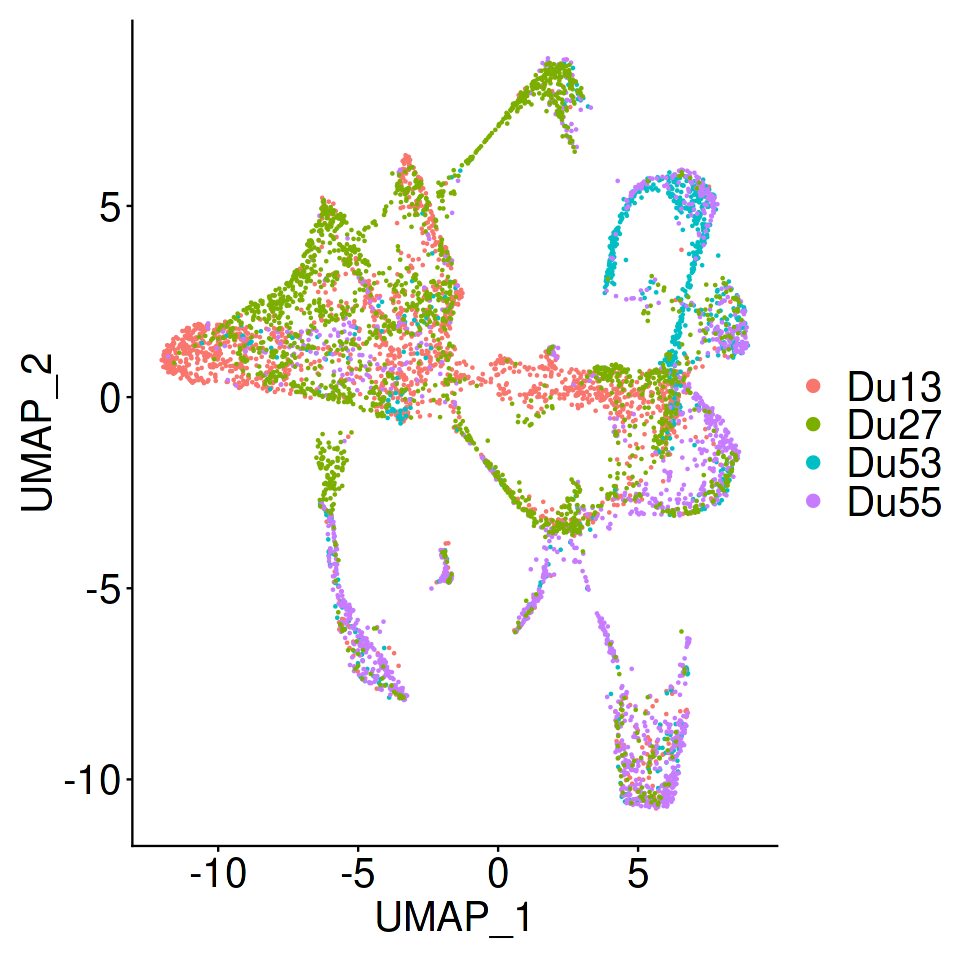

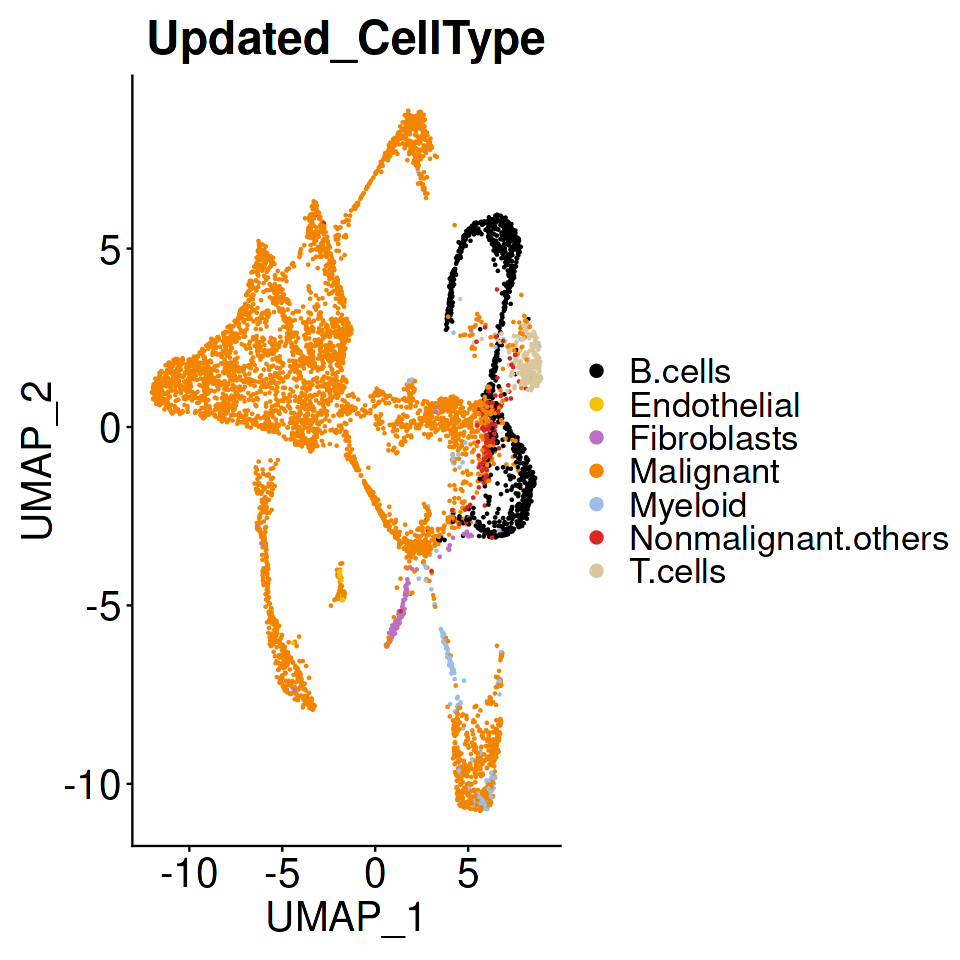

In [56]:
options(repr.plot.width = 8, repr.plot.height = 8)


cell_types_with_colors <- c("B.cells", "Endothelial", "Fibroblasts", "Malignant", "Myeloid", "Nonmalignant.others", "T.cells")
colors <- c("#000000", "#f3c300", "#bc70c4", "#f38400", "#9cbee5", "#d72828", "#d9c69c")
celltype_colors <- setNames(colors, cell_types_with_colors)

# Plot the first DimPlot with larger fonts and ticks
DimPlot(all_afm_scRNA, 
        reduction = "umap", 
        group.by = "orig.ident") + 
  theme(
    text = element_text(size = 24),         # Larger font for titles and labels
    axis.text = element_text(size = 24),    # Larger font for axis tick labels
    axis.title = element_text(size = 24),   # Larger font for axis titles
    legend.text = element_text(size = 24),
          plot.title = element_blank()            # Remove title # Adjust font for legend text if needed
  )

# Plot the second DimPlot with the specified color scheme, larger fonts, and ticks
DimPlot(all_afm_scRNA, 
        reduction = "umap", 
        group.by = "Updated_CellType", 
        cols = celltype_colors) +           # Apply custom color scheme
  theme(
    text = element_text(size = 24),         # Larger font for titles and labels
    axis.text = element_text(size = 24),    # Larger font for axis tick labels
    axis.title = element_text(size = 24),   # Larger font for axis titles

  )



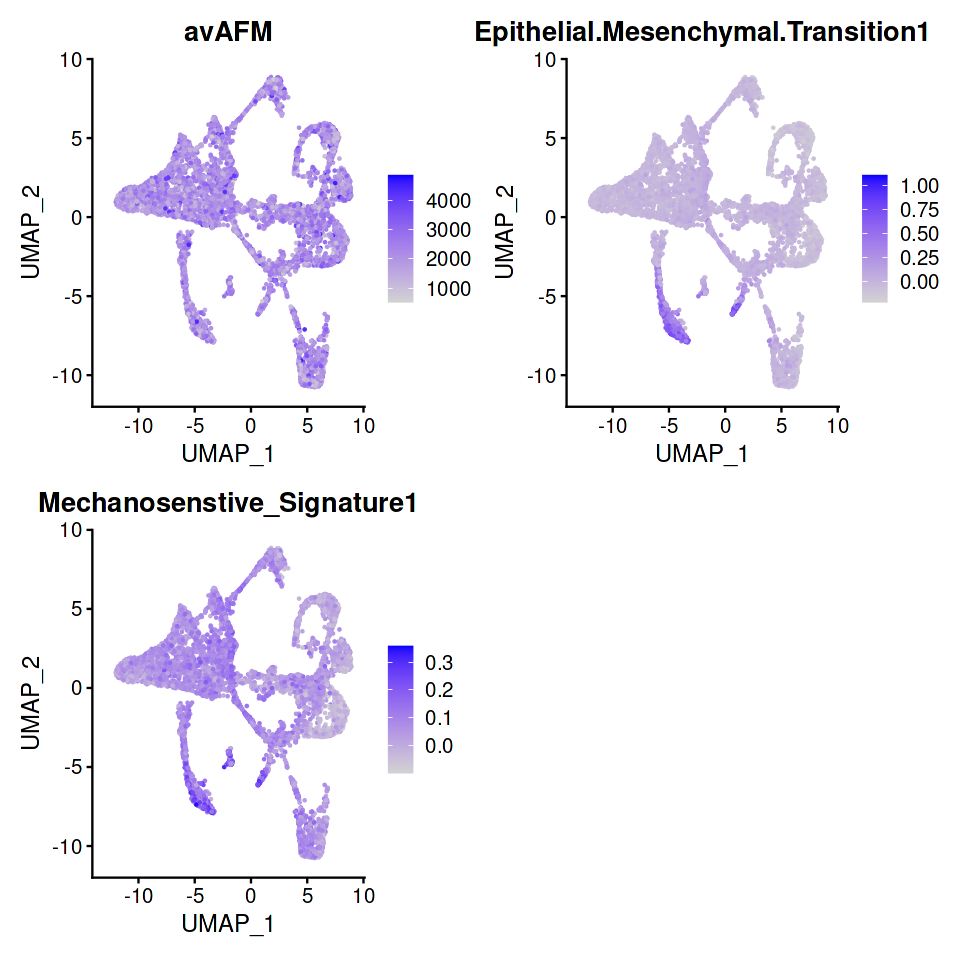

In [39]:
FeaturePlot(all_afm_scRNA, reduction = "umap", features = c("avAFM","Epithelial.Mesenchymal.Transition1", "Mechanosenstive_Signature1" ))


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4623
Number of edges: 145319

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6044
Number of communities: 68
Elapsed time: 0 seconds


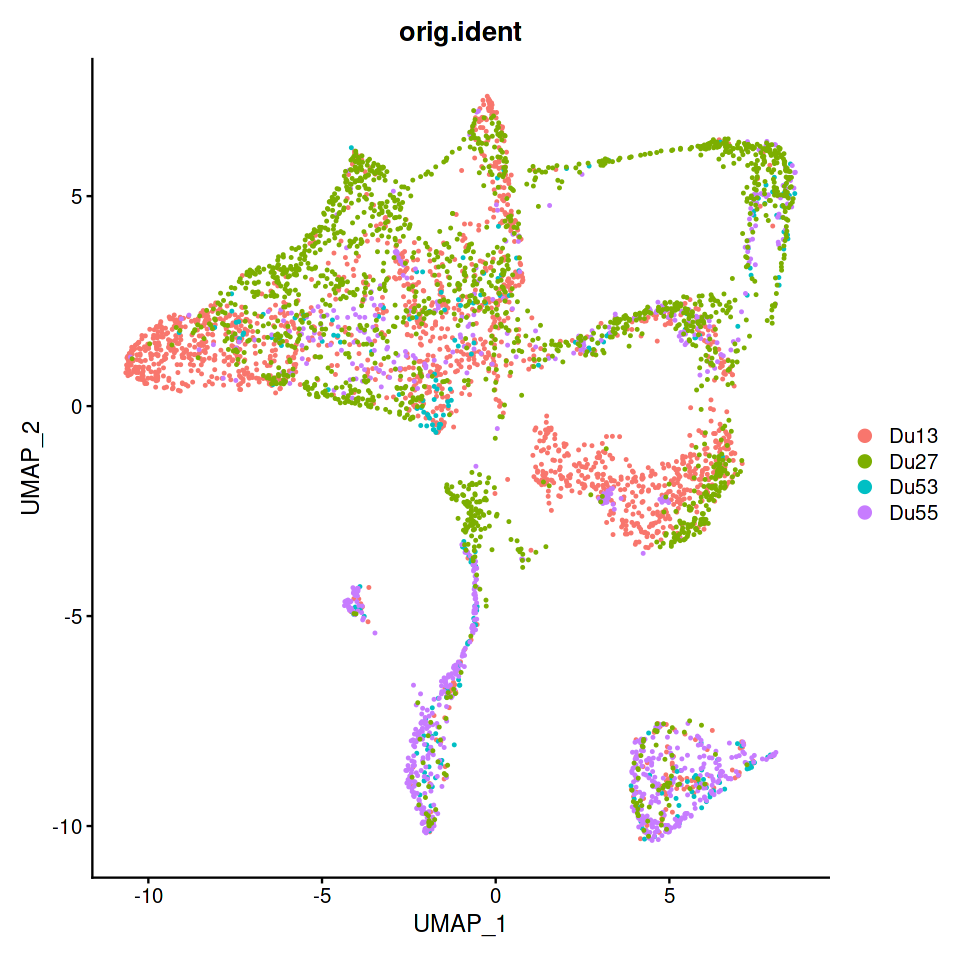

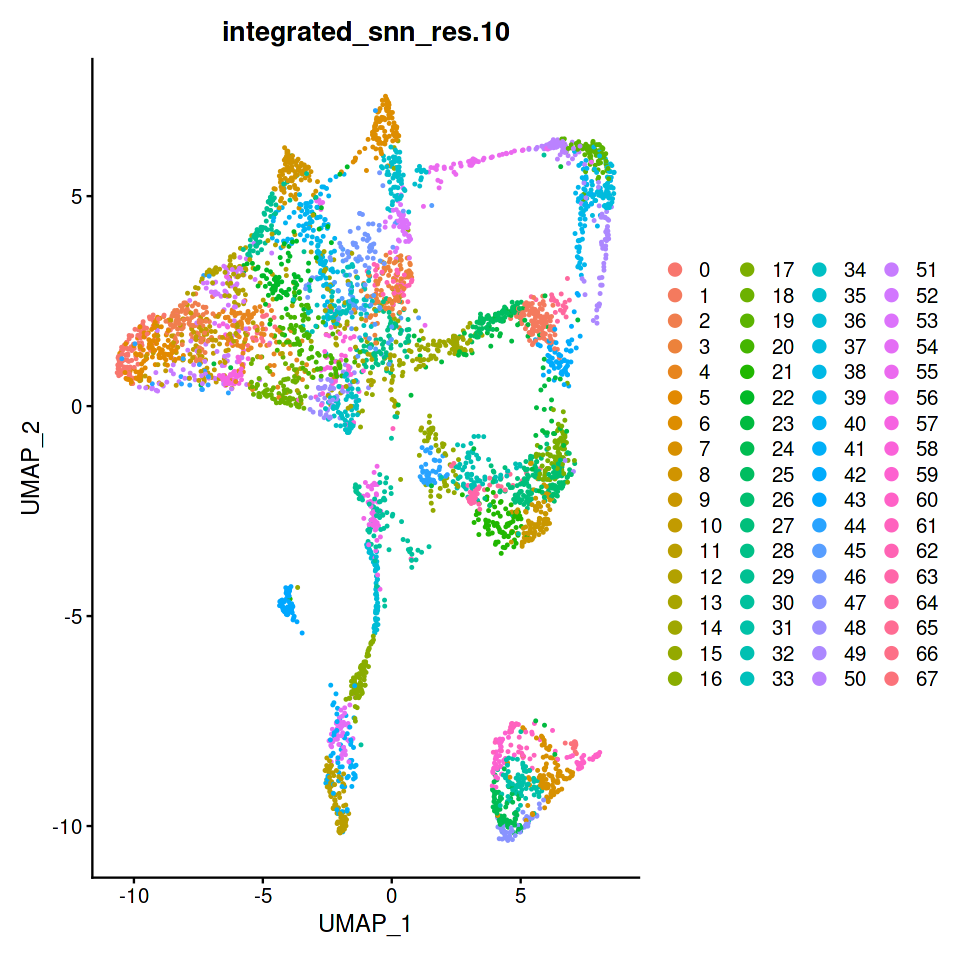

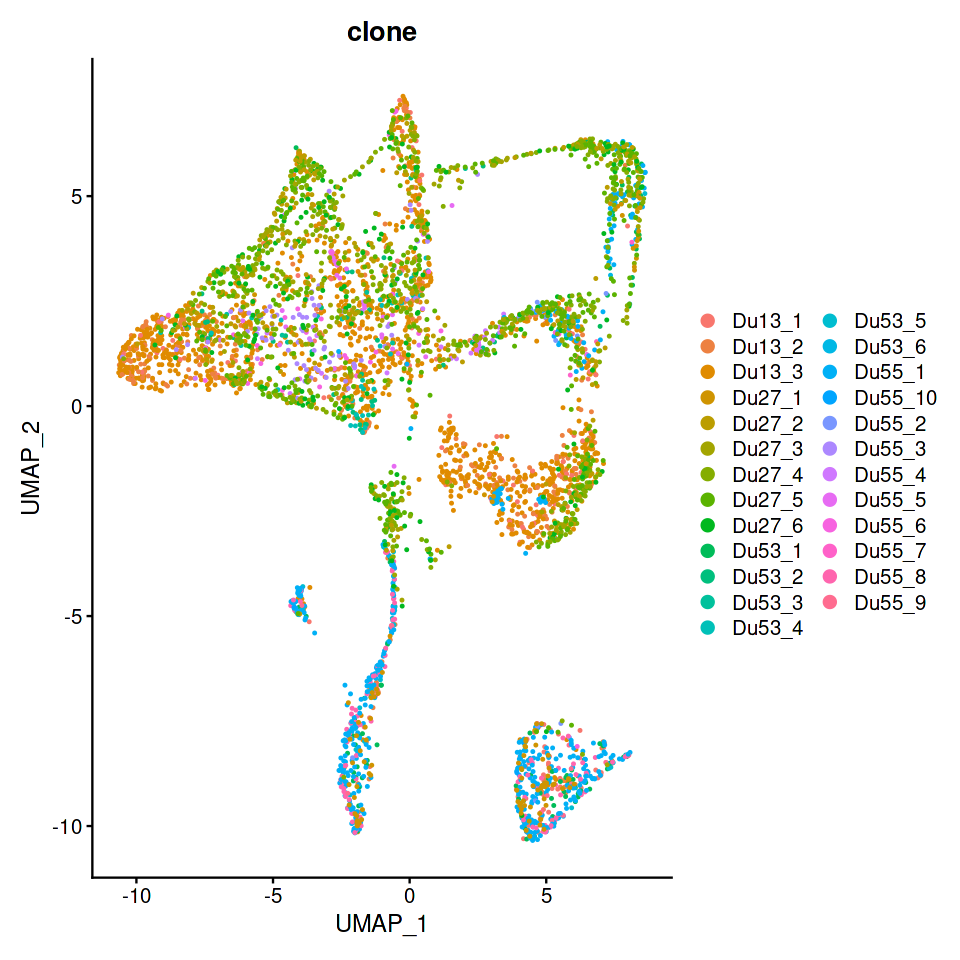

In [40]:
malig_only <- FindClusters(malig_only, resolution = 10)
DimPlot(malig_only, reduction = "umap", group.by = "orig.ident")
DimPlot(malig_only, reduction = "umap", group.by = "integrated_snn_res.10")
DimPlot(malig_only, reduction = "umap", group.by = "clone")


In [41]:

lcv_data <- malig_only@meta.data$avAFM
lcv_data <- as.vector((unlist(lcv_data)))

quartile_breaks <- quantile(lcv_data, probs = c(0, 0.25, 0.50, 0.75, 1), na.rm = TRUE)
    
malig_only@meta.data$quartile <- cut(lcv_data, 
                                   breaks = quartile_breaks, 
                                   include.lowest = TRUE,
                                   labels = c("Q1", "Q2", "Q3", "Q4"))
    
malig_only@meta.data$quartile <- lapply(malig_only@meta.data$CellName,
                                                function(x) malig_only@meta.data[x,]$quartile)

Idents(malig_only) <- 'quartile'
GSEA_Markers <- FindAllMarkers(malig_only, logfc.threshold = 0.05)       
    
Malig_Signature <- GSEA_Markers[GSEA_Markers$cluster == "Q4" & GSEA_Markers$p_val_adj < 1 & 
                  GSEA_Markers$avg_log2FC >0, ]$gene

Malig_Signature <- c(Malig_Signature,                                           
GSEA_Markers[GSEA_Markers$cluster == "Q1"  & GSEA_Markers$p_val_adj < 1 &
                  GSEA_Markers$avg_log2FC <0, ]$gene)


print(Malig_Signature)



Calculating cluster Q1

Calculating cluster Q2

Calculating cluster Q3

Calculating cluster Q4



 [1] "GHR"        "RPS23"      "VIM"        "AL033504.1" "A2M"       
 [6] "BACH2"      "DOK5"       "DLL4"       "PDLIM3"     "G0S2"      
[11] "SLC2A3"     "CLNK"       "FLT1"       "TMSB4X"     "SH3RF3"    
[16] "ARHGAP10"  


In [42]:
# Assuming 'malig_only' is your Seurat object
# Extract avAFM and orig.ident data from meta.data
metadata <- malig_only@meta.data %>% 
  select(avAFM, orig.ident, CellName)

# Compute quartiles within each 'orig.ident'
metadata <- metadata %>%
  group_by(orig.ident) %>%
  mutate(quartile = ntile(avAFM, 4)) %>%
  ungroup()

# Map computed quartiles back to Seurat object's metadata
malig_only@meta.data$quartile <- metadata$quartile

# Update identities in the Seurat object to new quartiles
Idents(malig_only) <- metadata$quartile

# Perform differential expression analysis
GSEA_Markers <- FindAllMarkers(malig_only, logfc.threshold = 0.05) 

# Extract genes for the malignancy signature based on new quartile assignments
Malig_Signature_quartile <- GSEA_Markers %>%
  filter((cluster == "4" & p_val_adj < 1 & avg_log2FC > 0) |
         (cluster == "1" & p_val_adj < 1 & avg_log2FC < 0)) %>%
  pull(gene)

Malig_Signature_quartile_neg <- GSEA_Markers %>%
  filter((cluster == "4" & p_val_adj < 1 & avg_log2FC < 0) |
         (cluster == "1" & p_val_adj < 1 & avg_log2FC > 0)) %>%
  pull(gene)


# Print the malignancy signature genes
print(Malig_Signature_quartile)


Calculating cluster 1

Calculating cluster 3

Calculating cluster 2

Calculating cluster 4



 [1] "LDLRAD3"    "SLC2A3"     "VIM"        "A2M"        "STAB1"     
 [6] "AL033504.1" "FLT1"       "PHLDA1"     "LTBP2"      "RTN1"      


In [43]:
Malig_Signature_quartile_neg

[1] "VEPH1"      "PTCHD1-AS"  "CYP4B1"     "SGPP2"      "AC044810.2"
 [6] "SGMS2"      "DPP4"       "TMEM132D"   "CDH1"       "TCIM"      
[11] "SYN3"       "MUC4"       "GPRC5A"     "ELF3"       "SERPINB1"  
[16] "MECOM"      "MACROD2"    "AGBL1"      "SLC7A2"     "SFTPA1"    
[21] "CTSE"       "SFTA3"      "SLC22A3"    "P3H2"       "ANXA3"     
[26] "NR6A1"      "ALPL"       "DUSP6"      "F3"         "CDHR3"     
[31] "LAMB3"      "TFCP2L1"    "KLF5"       "CD9"        "MAST4"     
[36] "EPS8"       "EHF"        "HOPX"       "SDC4"       "SNTB1"     
[41] "AC019117.2" "SHANK2"     "NEURL1B"    "ADGRF5"     "SFTPA2"    
[46] "WWTR1"      "GLIS3"      "PDE4D"      "RASEF"      "ICAM1"     
[51] "CFAP221"    "TM4SF1"     "VSTM2L"     "LMO3"       "CHL1"      
[56] "CAPN8"      "RNF150"     "MALL"       "CD38"       "DMBT1"     
[61] "ADGRV1"     "SLC6A14"    "CACNA2D2"   "ROS1"       "ERRFI1"    
[66] "PTGS2"      "GPR39"      "KRT8"       "LINC01811"  "CNTN6"     
[71] "FAM155A"

In [ ]:
DefaultAssay(malig_only) <-"RNA"
malig_only<- AddModuleScore(malig_only,
                                  features = list(Malig_Signature),
                                  name=c(paste0("malig_integrated_signature")))

malig_only<- AddModuleScore(malig_only,
                                  features = list(Malig_Signature_quartile),
                                  name=c(paste0("malig_integrated_signature_by_sample")))

malig_only<- AddModuleScore(malig_only,
                                  features = list(Malig_Signature_quartile_neg),
                                  name=c(paste0("malig_integrated_signature_by_sample_negUpperQ_poslowerQ")))

malig_only<- AddModuleScore(malig_only,
                                  features = list(subset(read.csv("NCBI_gene_result.xlsx - Cells.csv"), Cell == "Malignant cells")$Gene.ID),
                                  name=c(paste0("malig_gene_only_integrated_signature")))
for (key in names(sig1)) {
           malig_only <- AddModuleScore(malig_only,
                                  features = list(sig1[[key]]),
                                  name=paste0(key, "_Hallmark"))
        }

for (key in names(sig2)) {
#           malig_only <- AddModuleScore(malig_only,features = list(sig2[[key]]),name=paste0(key, "_GO"))
        }

DefaultAssay(malig_only) <-"integrated"



Warning message:
“The following features are not present in the object: SLUG, , not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: MTARC2, ADIPOQ, not searching for symbol synonyms”


In [50]:

DefaultAssay(malig_only) <-"integrated"

#write.csv(apply(malig_only@meta.data,2,as.character), "data_storage/integrated_data/malignant_merged_pathways_allGO.csv")
write.csv(apply(malig_only@meta.data,2,as.character), "data_storage/integrated_data/malignant_merged_pathways_reint_newclassv2.csv")
saveRDS(malig_only, "integrated_data/malignant_reint_newclassv2.rds")

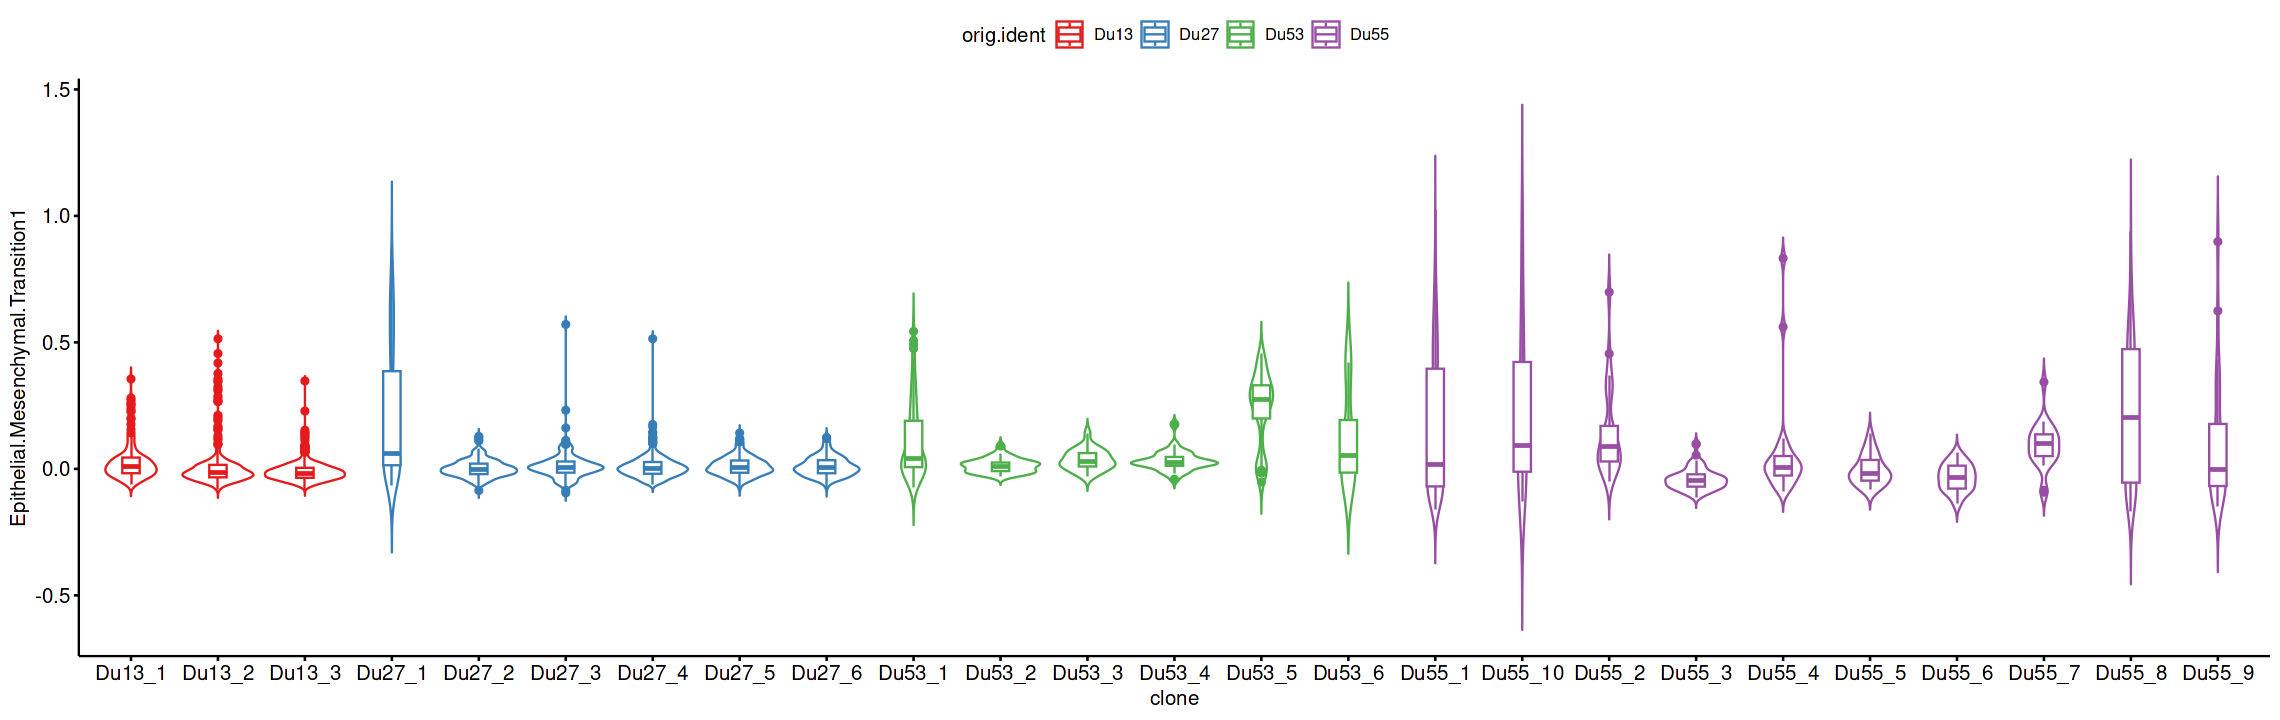

In [94]:
options(repr.plot.width=19, repr.plot.height=6)
sorted_data <- malig_only@meta.data %>% arrange(clone)

# Sort the dataframe by the "clone" column
sorted_data <- malig_only@meta.data %>% arrange(clone)

# Set the plot width and height
options(repr.plot.width=19, repr.plot.height=6)

# Define a color palette
color_palette <- brewer.pal(n = length(unique(sorted_data$orig.ident)), name = "Set1")


ggviolin(sorted_data, x = "clone", y = "Epithelial.Mesenchymal.Transition1",
         add = "boxplot", add.params = list(fill = "white"),
         color = "orig.ident", palette = color_palette)


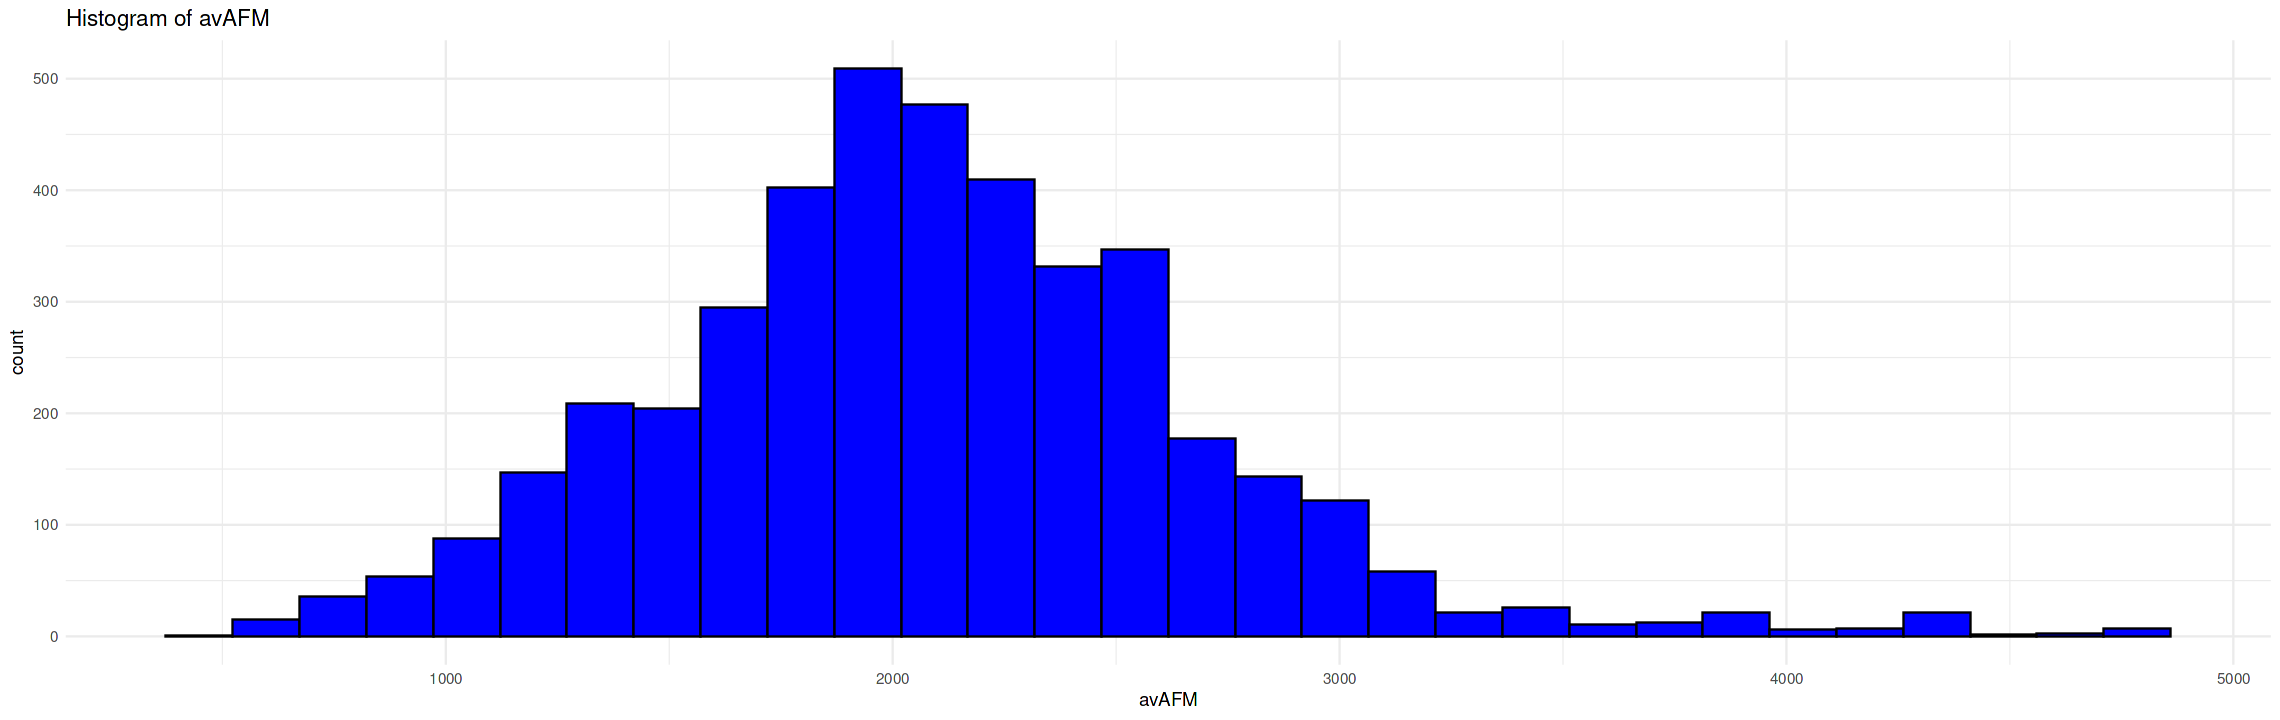

In [95]:


ggplot(malig_only@meta.data, aes(x = avAFM)) +
    geom_histogram(bins = 30, fill = "blue", color = "black") +
    theme_minimal() +
    ggtitle("Histogram of avAFM")

In [ ]:
options(repr.plot.width=19, repr.plot.height=6)
sorted_data <- malig_only@meta.data %>% arrange(clone)

# Sort the dataframe by the "clone" column
sorted_data <- malig_only@meta.data %>% arrange(clone)

# Set the plot width and height
options(repr.plot.width=19, repr.plot.height=6)

# Define a color palette
color_palette <- brewer.pal(n = length(unique(sorted_data$orig.ident)), name = "Set1")


ggviolin(sorted_data, x = "clone", y = "avAFM",
         add = "boxplot", add.params = list(fill = "white"),
         color = "orig.ident", palette = color_palette)

In [ ]:
options(repr.plot.width=19, repr.plot.height=6)
sorted_data <- malig_only@meta.data %>% arrange(clone)

# Sort the dataframe by the "clone" column
sorted_data <- malig_only@meta.data %>% arrange(clone)

# Set the plot width and height
options(repr.plot.width=19, repr.plot.height=6)

# Define a color palette
color_palette <- brewer.pal(n = length(unique(sorted_data$orig.ident)), name = "Set1")


ggviolin(sorted_data, x = "clone", y = "Mechanosenstive_Signature1",
         add = "boxplot", add.params = list(fill = "white"),
         color = "orig.ident", palette = color_palette)

In [ ]:
all_afm_scRNA@meta.data

In [ ]:

library(FSA)  # For Dunn's test

# Set plot dimensions
options(repr.plot.width=19, repr.plot.height=6)

# Sort data by clone
sorted_data <- malig_only@meta.data %>% arrange(clone)

# Define a color palette
color_palette <- brewer.pal(n = length(unique(sorted_data$orig.ident)), name = "Set1")

# Boxplot with ggplot2
ggplot(sorted_data, aes(x = clone, y = avAFM, fill = orig.ident)) +
  geom_violin(trim = FALSE) +
  geom_boxplot(width = 0.1, position = position_dodge(0.9), fill = "white") +
  scale_fill_manual(values = color_palette) +
  theme_classic() +
  labs(title = "AFM Values by Clone", x = "Clone", y = "AFM Value")

# Perform Kruskal-Wallis test to check for overall differences
kruskal_test <- kruskal.test(avAFM ~ clone, data = sorted_data)
kruskal_test

# Perform Dunn's test for pairwise comparisons
dunn_test <- dunnTest(avAFM ~ clone, data = sorted_data, method = "bonferroni")
dunn_test

# Extract significant results (p-value < 0.05)
significant_results <- dunn_test$res %>% filter(P.adj < 0.05)
significant_results


In [ ]:
malig_only@meta.data



In [71]:
# Assuming 'malig_only' is your Seurat object
# Extract avAFM and orig.ident data from meta.data
metadata <- malig_only@meta.data %>% 
  select(avAFM, orig.ident, CellName)

# Compute quartiles within each 'orig.ident'
metadata <- metadata %>%
  group_by(orig.ident) %>%
  mutate(quartile = ntile(avAFM, 4)) %>%
  ungroup()

# Map computed quartiles back to Seurat object's metadata
malig_only@meta.data$quartile <- metadata$quartile

# Update identities in the Seurat object to new quartiles
Idents(malig_only) <- metadata$quartile

# Perform differential expression analysis
GSEA_Markers <- FindAllMarkers(malig_only, logfc.threshold = 0.05) 

# Extract genes for the malignancy signature based on new quartile assignments
Malig_Signature_quartile <- GSEA_Markers %>%
  filter((cluster== "4" & p_val_adj < 1 & avg_log2FC > 0) |
         (cluster == "1" & p_val_adj < 1 & avg_log2FC < 0)) %>%
  pull(gene)

# Print the malignancy signature genes
print(Malig_Signature_quartile)

Malig_Signature_quartile_neg <- GSEA_Markers %>%
  filter((cluster == "4" & p_val_adj < 1 & avg_log2FC < 0) |
         (cluster == "1" & p_val_adj < 1 & avg_log2FC > 0)) %>%
  pull(gene)

Malig_Signature_quartile_neg_v2 <- GSEA_Markers %>%
  filter((cluster == "4" & p_val_adj < 1 & avg_log2FC < 0) |
         (cluster == "1" & p_val_adj < 1 & avg_log2FC > 0) |
         (cluster == "2" & p_val_adj < 1 & avg_log2FC > 0)) %>%
  pull(gene)

Calculating cluster 1

Calculating cluster 3

Calculating cluster 2

Calculating cluster 4



 [1] "A2M"     "VIM"     "LDLRAD3" "STAB1"   "SLC2A3"  "TCF4"    "IGF1"   
 [8] "ZEB2"    "GAS7"    "RTN1"    "LTBP2"   "FLT1"   


In [72]:
Malig_Signature_quartile
Malig_Signature_quartile_neg
mechano_signature

[1] "A2M"     "VIM"     "LDLRAD3" "STAB1"   "SLC2A3"  "TCF4"    "IGF1"   
 [8] "ZEB2"    "GAS7"    "RTN1"    "LTBP2"   "FLT1"

[1] "VEPH1"      "SGPP2"      "MACROD2"    "MECOM"      "CYP4B1"    
 [6] "AC044810.2" "SGMS2"      "TMEM132D"   "PTCHD1-AS"  "SERPINB1"  
[11] "SLC7A2"     "TCIM"       "CDH1"       "PHACTR3"    "GPRC5A"    
[16] "SYN3"       "BPIFB1"     "DUSP6"      "ANXA3"      "MUC4"      
[21] "AL138720.1" "KRT7"       "ELF3"       "CTSE"       "F3"        
[26] "SFTPB"      "PDE4D"      "CHL1"       "SFTPA1"     "SCNN1G"    
[31] "AGBL1"      "DPP4"       "LTF"        "ROS1"       "KRT17"     
[36] "CDHR3"      "SLC22A3"    "HOPX"       "ALPL"       "TFCP2L1"   
[41] "COL25A1"    "LMO7"       "AC112206.2" "PTGS2"      "NR6A1"     
[46] "LAMB3"      "SLC6A14"    "P3H2"       "MAST4"      "RIMS1"     
[51] "CAPN8"      "MALL"       "WWTR1"      "SNTB1"      "ADGRV1"    
[56] "CD38"       "LMO3"       "ANK3"       "KRT8"       "HYDIN"     
[61] "SFTPA2"     "NEBL"       "SLPI"       "GPR39"      "SHANK2"    
[66] "RASEF"      "SFTA3"      "ICAM1"      "EPS8"       "DMBT1"     
[71] "AC019117.2" "RNF150"     "EHF"        "ERRFI1"     "COBL"      
[76] "CD9"        "LINC01811"  "ALCAM"      "CFAP221"    "CD55"      
[81] "CNTN6"      "EFNA5"      "ST18"       "DANT2"      "KIAA1211L" 
[86] "SDC4"       "SCGB3A2"

[1] "TP53"      "MAPK1"     "YAP1"      "ITGB1"     "LMNA"      "PTK2"     
  [7] "HSPB1"     "PKD1"      "JAG1"      "PIEZO1"    "TRPM7"     "CDH5"     
 [13] "PKD2"      "BCAR1"     "VCL"       "NOTCH4"    "FLNC"      "CTNNA1"   
 [19] "ADAM15"    "PLS3"      "MGAT5"     "LDB3"      "ANKRD2"    "TMIGD2"   
 [25] "TGFB1"     "TNF"       "NOS3"      "MTOR"      "SIRT1"     "CCND1"    
 [31] "HMGB1"     "NOTCH1"    "MAPK14"    "MAPK3"     "AGTR1"     "EDN1"     
 [37] "CCN2"      "GJA1"      "TNFRSF11B" "COL1A1"    "FN1"       "FGF2"     
 [43] "BMP2"      "RUNX2"     "CHI3L1"    "TNFSF11"   "NAMPT"     "GNAS"     
 [49] "SOX9"      "PGF"       "ROCK1"     "ITGA5"     "MUC5AC"    "GFAP"     
 [55] "CTSB"      "TRAF2"     "FURIN"     "MAP1LC3A"  "SRSF1"     "TRPA1"    
 [61] "CYP24A1"   "MUC5B"     "CTSL"      "SFRP1"     "ACTA2"     "KRT5"     
 [67] "COL4A1"    "DYSF"      "SMAD1"     "KMT2D"     "DES"       "KRT14"    
 [73] "MYLK"      "DSG1"      "MIR378A"   "CAV3"      "TMSB4X"    "DSG3"     
 [79] "KRIT1"     "CMA1"      "MIR152"    "ADORA2B"   "ANGPTL2"   "COL4A2"   
 [85] "SMARCE1"   "BMP1"      "DSC2"      "SP7"       "MAPK8IP1"  "ZIC1"     
 [91] "XYLT1"     "SYNM"      "EHD2"      "MIR432"    "GPRC5B"    "SMPX"     
 [97] "ITGB1BP2"  "PALMD"     "NEWENTRY"  "MIR3198-2" "MIR3198-1" "EGFR"     
[103] "AKT1"      "CDH1"      "PTGS2"     "NFE2L2"    "CAV1"      "SRC"      
[109] "ITGB3"     "VWF"       "RHOA"      "VHL"       "MAPK8"     "PRKCA"    
[115] "TWIST1"    "MMP14"     "THBS1"     "ITGB2"     "PRKAA1"    "WNT5A"    
[121] "ITGA2B"    "PAK1"      "SELE"      "FLNA"      "OLR1"      "TRPV4"    
[127] "SOST"      "ITGA2"     "DNM1L"     "WWTR1"     "PECAM1"    "GP1BA"    
[133] "PXN"       "TREM1"     "CD47"      "CXCL1"     "FSCN1"     "LOX"      
[139] "BAG3"      "KCNMA1"    "TACR1"     "WNT1"      "CGAS"      "TAC1"     
[145] "ULK1"      "NFATC2"    "KCNN4"     "TRPC1"     "KLF2"      "SDC4"     
[151] "ACTN1"     "PANX1"     "MRTFA"     "PPP1R12A"  "WWC1"      "YES1"     
[157] "ASIC1"     "PKHD1"     "KCNK2"     "SLAMF1"    "PDCD10"    "RRM2B"    
[163] "MYL2"      "ITGB7"     "ARHGEF2"   "PDLIM7"    "DMP1"      "TMC1"     
[169] "G3BP2"     "PDLIM5"    "RAP2A"     "GPSM2"     "ASIC2"     "ARHGAP24" 
[175] "CLRN1"     "ULK2"      "CIB2"      "SYNE3"     "JCAD"      "TMC2"     
[181] "CRACD"     "CRYBG3"    "ARHGEF40"  "UNC50"     "CIB3"      ""

In [73]:
max_length <- max(length(Malig_Signature_quartile), length(Malig_Signature_quartile_neg), length(mechano_signature))

Malig_Signature_quartile <- c(Malig_Signature_quartile, rep(NA, max_length - length(Malig_Signature_quartile)))
Malig_Signature_quartile_neg <- c(Malig_Signature_quartile_neg, rep(NA, max_length - length(Malig_Signature_quartile_neg)))
mechano_signature <- c(mechano_signature, rep(NA, max_length - length(mechano_signature)))

# Combine into a data frame
data_table <- data.frame(
  Malig_Signature_quartile,
  Malig_Signature_quartile_neg,
  mechano_signature
)

# Save to CSV
write.csv(data_table, "Supplemental_Table2.csv", row.names = FALSE)


[1] "TP53"      "MAPK1"     "YAP1"      "ITGB1"     "LMNA"      "PTK2"     
  [7] "HSPB1"     "PKD1"      "JAG1"      "PIEZO1"    "TRPM7"     "CDH5"     
 [13] "PKD2"      "BCAR1"     "VCL"       "NOTCH4"    "FLNC"      "CTNNA1"   
 [19] "ADAM15"    "PLS3"      "MGAT5"     "LDB3"      "ANKRD2"    "TMIGD2"   
 [25] "TGFB1"     "TNF"       "NOS3"      "MTOR"      "SIRT1"     "CCND1"    
 [31] "HMGB1"     "NOTCH1"    "MAPK14"    "MAPK3"     "AGTR1"     "EDN1"     
 [37] "CCN2"      "GJA1"      "TNFRSF11B" "COL1A1"    "FN1"       "FGF2"     
 [43] "BMP2"      "RUNX2"     "CHI3L1"    "TNFSF11"   "NAMPT"     "GNAS"     
 [49] "SOX9"      "PGF"       "ROCK1"     "ITGA5"     "MUC5AC"    "GFAP"     
 [55] "CTSB"      "TRAF2"     "FURIN"     "MAP1LC3A"  "SRSF1"     "TRPA1"    
 [61] "CYP24A1"   "MUC5B"     "CTSL"      "SFRP1"     "ACTA2"     "KRT5"     
 [67] "COL4A1"    "DYSF"      "SMAD1"     "KMT2D"     "DES"       "KRT14"    
 [73] "MYLK"      "DSG1"      "MIR378A"   "CAV3"      "TMSB4X"    "DSG3"     
 [79] "KRIT1"     "CMA1"      "MIR152"    "ADORA2B"   "ANGPTL2"   "COL4A2"   
 [85] "SMARCE1"   "BMP1"      "DSC2"      "SP7"       "MAPK8IP1"  "ZIC1"     
 [91] "XYLT1"     "SYNM"      "EHD2"      "MIR432"    "GPRC5B"    "SMPX"     
 [97] "ITGB1BP2"  "PALMD"     "NEWENTRY"  "MIR3198-2" "MIR3198-1" "EGFR"     
[103] "AKT1"      "CDH1"      "PTGS2"     "NFE2L2"    "CAV1"      "SRC"      
[109] "ITGB3"     "VWF"       "RHOA"      "VHL"       "MAPK8"     "PRKCA"    
[115] "TWIST1"    "MMP14"     "THBS1"     "ITGB2"     "PRKAA1"    "WNT5A"    
[121] "ITGA2B"    "PAK1"      "SELE"      "FLNA"      "OLR1"      "TRPV4"    
[127] "SOST"      "ITGA2"     "DNM1L"     "WWTR1"     "PECAM1"    "GP1BA"    
[133] "PXN"       "TREM1"     "CD47"      "CXCL1"     "FSCN1"     "LOX"      
[139] "BAG3"      "KCNMA1"    "TACR1"     "WNT1"      "CGAS"      "TAC1"     
[145] "ULK1"      "NFATC2"    "KCNN4"     "TRPC1"     "KLF2"      "SDC4"     
[151] "ACTN1"     "PANX1"     "MRTFA"     "PPP1R12A"  "WWC1"      "YES1"     
[157] "ASIC1"     "PKHD1"     "KCNK2"     "SLAMF1"    "PDCD10"    "RRM2B"    
[163] "MYL2"      "ITGB7"     "ARHGEF2"   "PDLIM7"    "DMP1"      "TMC1"     
[169] "G3BP2"     "PDLIM5"    "RAP2A"     "GPSM2"     "ASIC2"     "ARHGAP24" 
[175] "CLRN1"     "ULK2"      "CIB2"      "SYNE3"     "JCAD"      "TMC2"     
[181] "CRACD"     "CRYBG3"    "ARHGEF40"  "UNC50"     "CIB3"      ""

In [ ]:
genes <- Malig_Signature_quartile

# Load Enrichr
setEnrichrSite("Enrichr") # Human genes
websiteLive <- TRUE
dbs <- listEnrichrDbs()
if (is.null(dbs)) websiteLive <- FALSE
if (websiteLive) head(dbs)
dbs <- c("MSigDB_Hallmark_2020","GO_Biological_Process_2023")
if (websiteLive) {
  enriched <- enrichr(genes, dbs)
}
mut_enr_ch<-mutate(enriched[[1]], qscore = -log(Adjusted.P.value, base=10))
mut_enr_go<-mutate(enriched[[2]], qscore = -log(Adjusted.P.value, base=10))
mut_enr <- rbind.data.frame(mut_enr_ch,mut_enr_go)
#mut_enr <- subset(mut_enr, P.value	 < 0.05 & qscore > 5)

#mut_enr<- mut_enr[order(mut_enr$Adjusted.P.value),]
mp = ""
cohort = "Cells Affillated with Highest Quartile AFM Measurements"
enrichdbs = "Cancer_Hallmarks_and_Gene_Ontology"
topn = ""


h_mut_enr1 <- mut_enr[1:25,]
h_mut_enr <- h_mut_enr1
ggp<- h_mut_enr %>%
  ggplot(aes(qscore, reorder(Term, qscore), fill = P.value)) +
  scale_fill_gradient(low = "red", high = "blue") +
  geom_bar(stat = "identity") +
  theme(legend.position = "bottom",
        axis.title.y = element_blank()
  ) +
  geom_text(
    aes(label = paste("P.val=", round(P.value,3))),
    color = "black",
    size = 4,
    hjust = 1, nudge_x = 2
  ) + theme_bw()
myggp<-ggp + scale_y_discrete(labels = function(x) str_wrap(x, width = 50))+ggtitle(paste(mp,": ",cohort,"\n",enrichdbs,": top = ",topn,"_genes")) +xlab("qscore") + ylab("Description")
myggp

In [ ]:
genes <- Malig_Signature_quartile_neg

# Load Enrichr
setEnrichrSite("Enrichr") # Human genes
websiteLive <- TRUE
dbs <- listEnrichrDbs()
if (is.null(dbs)) websiteLive <- FALSE
if (websiteLive) head(dbs)
dbs <- c("MSigDB_Hallmark_2020","GO_Biological_Process_2023")
if (websiteLive) {
  enriched <- enrichr(genes, dbs)
}
mut_enr_ch<-mutate(enriched[[1]], qscore = -log(Adjusted.P.value, base=10))
mut_enr_go<-mutate(enriched[[2]], qscore = -log(Adjusted.P.value, base=10))
mut_enr <- rbind.data.frame(mut_enr_ch,mut_enr_go)

#mut_enr<- mut_enr[order(mut_enr$Adjusted.P.value),]
mp = ""
cohort = "Cells Affillated with Highest Quartile AFM Measurements"
enrichdbs = "Cancer_Hallmarks_and_Gene_Ontology"
topn = ""


h_mut_enr1 <- mut_enr[1:25,]
h_mut_enr <- h_mut_enr1
ggp<- h_mut_enr %>%
  ggplot(aes(qscore, reorder(Term, qscore), fill = P.value)) +
  scale_fill_gradient(low = "red", high = "blue") +
  geom_bar(stat = "identity") +
  theme(legend.position = "bottom",
        axis.title.y = element_blank()
  ) +
  geom_text(
    aes(label = paste("P.val=", round(P.value,3))),
    color = "black",
    size = 4,
    hjust = 1, nudge_x = 2
  ) + theme_bw()
myggp<-ggp + scale_y_discrete(labels = function(x) str_wrap(x, width = 50))+ggtitle(paste(mp,": ",cohort,"\n",enrichdbs,": top = ",topn,"_genes")) +xlab("qscore") + ylab("Description")
myggp

In [ ]:

sig1 <- processFile("../mice_samples/all_completed_alignments/LCV01/MSigDB_Hallmark_2020.txt")
sig1
for (sc_spot in 1:length(spatial.AFM)){
    
   spatial.AFM[[sc_spot]] <- AddModuleScore(spatial.AFM[[sc_spot]],
                                  features = list(Malig_Signature),
                                  name=paste0("malig_integrated_signature"))
       spatial.AFM[[sc_spot]] <- AddModuleScore(spatial.AFM[[sc_spot]],
                                  features = list(Malig_Signature_quartile),
                                  name=paste0("malig_integrated_signature_by_sample"))
       spatial.AFM[[sc_spot]] <- AddModuleScore(spatial.AFM[[sc_spot]],
                                  features = list(Malig_Signature_quartile_neg),
                                  name=paste0("malig_integrated_signature_by_sample_negUpperQ_poslowerQ"))
        for (key in names(sig1)) {
           spatial.AFM[[sc_spot]] <- AddModuleScore(spatial.AFM[[sc_spot]],
                                  features = list(sig1[[key]]),
                                  name=paste0(key, "_Hallmark"))
        }
    

}

In [ ]:
scRNA.AFM[[1]]

In [ ]:
merged_spatial_AFM <- merge(spatial.AFM[[1]], y = spatial.AFM[2:length(spatial.AFM)])


In [ ]:
saveRDS(merged_spatial_AFM, file = "Processed_Spatial_Data/merged_spatial_AFM.rds")
write.csv(merged_spatial_AFM@meta.data, "Processed_Spatial_Data/merged_spatial_AFM_metadata.csv")

In [ ]:
merged_spatial_AFM <- ScaleData(merged_spatial_AFM)

merged_spatial_AFM <- FindVariableFeatures(merged_spatial_AFM)

merged_spatial_AFM <- RunPCA(merged_spatial_AFM)

merged_spatial_AFM <- FindNeighbors(merged_spatial_AFM, dims = 1:10)
merged_spatial_AFM <- FindClusters(merged_spatial_AFM, resolution = 0.5)
merged_spatial_AFM <- RunUMAP(myeloid_cells, dims = 1:10)

DimPlot(merged_spatial_AFM, reduction = "umap", group.by = "orig.ident")


In [45]:
# Assuming 'malig_only' is your Seurat object
# Extract avAFM and orig.ident data from meta.data
metadata <- non_malig@meta.data %>% 
  select(avAFM, orig.ident, CellName)

# Compute quartiles within each 'orig.ident'
metadata <- metadata %>%
  group_by(orig.ident) %>%
  mutate(quartile = ntile(avAFM, 4)) %>%
  ungroup()

# Map computed quartiles back to Seurat object's metadata
non_malig@meta.data$quartile <- metadata$quartile

# Update identities in the Seurat object to new quartiles
Idents(non_malig) <- metadata$quartile

# Perform differential expression analysis
GSEA_Markers <- FindAllMarkers(non_malig, logfc.threshold = 0.05) 

# Extract genes for the malignancy signature based on new quartile assignments
non_malig_signature_quartile <- GSEA_Markers %>%
  filter((cluster == "4" & p_val_adj < 1 & avg_log2FC > 0) |
         (cluster == "1" & p_val_adj < 1 & avg_log2FC < 0)) %>%
  pull(gene)

non_malig_signature_quartile_neg <- GSEA_Markers %>%
  filter((cluster == "4" & p_val_adj < 1 & avg_log2FC < 0) |
         (cluster == "1" & p_val_adj < 1 & avg_log2FC > 0)) %>%
  pull(gene)


# Print the malignancy signature genes
print(non_malig_signature_quartile)


Calculating cluster 3

Calculating cluster 2



In [ ]:
DefaultAssay(non_malig) <-"RNA"
non_malig<- AddModuleScore(non_malig,
                                  features = list(Malig_Signature),
                                  name=c(paste0("malig_integrated_signature")))

non_malig<- AddModuleScore(non_malig,
                                  features = list(Malig_Signature_quartile),
                                  name=c(paste0("malig_integrated_signature_by_sample")))

non_malig<- AddModuleScore(non_malig,
                                  features = list(Malig_Signature_quartile_neg),
                                  name=c(paste0("malig_integrated_signature_by_sample_negUpperQ_poslowerQ")))

non_malig<- AddModuleScore(non_malig,
                                  features = list(subset(read.csv("NCBI_gene_result.xlsx - Cells.csv"), Cell == "Malignant cells")$Gene.ID),
                                  name=c(paste0("malig_gene_only_integrated_signature")))


non_malig<- AddModuleScore(non_malig,
                                  features = list(non_malig_signature_quartile),
                                  name=c(paste0("non_malig_signature_quartile_by_sample")))

non_malig<- AddModuleScore(non_malig,
                                  features = list(non_malig_signature_quartile_neg),
                                  name=c(paste0("non_malig_signature_quartile_by_sample_neg")))


for (key in names(sig1)) {
           non_malig <- AddModuleScore(non_malig,
                                  features = list(sig1[[key]]),
                                  name=paste0(key, "_Hallmark"))
        }

DefaultAssay(non_malig) <-"integrated"



In [ ]:
write.csv(apply(non_malig@meta.data,2,as.character), "data_storage/integrated_data/non_malignant_merged_pathways.csv")
